# Beasts Through the Ages: A Temporal Analysis of Animal Representations in Text
# By Bar Dolev - 318419512

# Imports

In [1]:
!pip install requests pandas --quiet

import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt', download_dir='/tmp/nltk_data')
nltk.data.path.append('/tmp/nltk_data')
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
import re
from collections import defaultdict, Counter
import gc
import os
import csv
import time
import spacy
from tqdm import tqdm
nlp = spacy.load("en_core_web_sm")
import networkx as nx

[nltk_data] Downloading package punkt to /tmp/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
animals = [
    'lion', 'eagle', 'raven', 'owl', 'cat', 'dog', 'snake',
    'deer', 'bat', 'rabbit', 'whale', 'shark', 'tiger',
    'panther', 'crocodile', 'monkey', 'wolf', 'fox', 'horse', 'dolphin'
]

# Data for mentions counts in google with ngrams

In [3]:
def fetch_ngram(term: str,
                corpus: int = 15,
                year_start: int = 1000,
                year_end: int = 2020,
                smoothing: int = 0) -> pd.DataFrame:
    """
    Fetches yearly frequencies for a given term from Google Books Ngram Viewer endpoint.
    Returns a DataFrame with columns ['year', 'frequency'].
    """
    url = "https://books.google.com/ngrams/json"
    params = {
        'content': term,
        'year_start': year_start,
        'year_end': year_end,
        'corpus': corpus,       # 15 = English
        'smoothing': smoothing, # smoothing window (0 = no smoothing)
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    if not data:
        raise ValueError(f"No data returned for term '{term}'")
    timeseries = data[0]['timeseries']
    years = list(range(year_start, year_end + 1))
    return pd.DataFrame({'year': years, term: timeseries})


In [4]:
# this makes animal_dfs a dict mapping name→DataFrame
animal_dfs = {
    animal: fetch_ngram(animal, year_start=1700, year_end=2000, smoothing=3)
    for animal in animals
}


In [5]:
# Merge into one wide DataFrame
df_all = pd.DataFrame({'year': animal_dfs[animals[0]]['year']})
for animal, df in animal_dfs.items():
    df_all[animal] = df[animal]

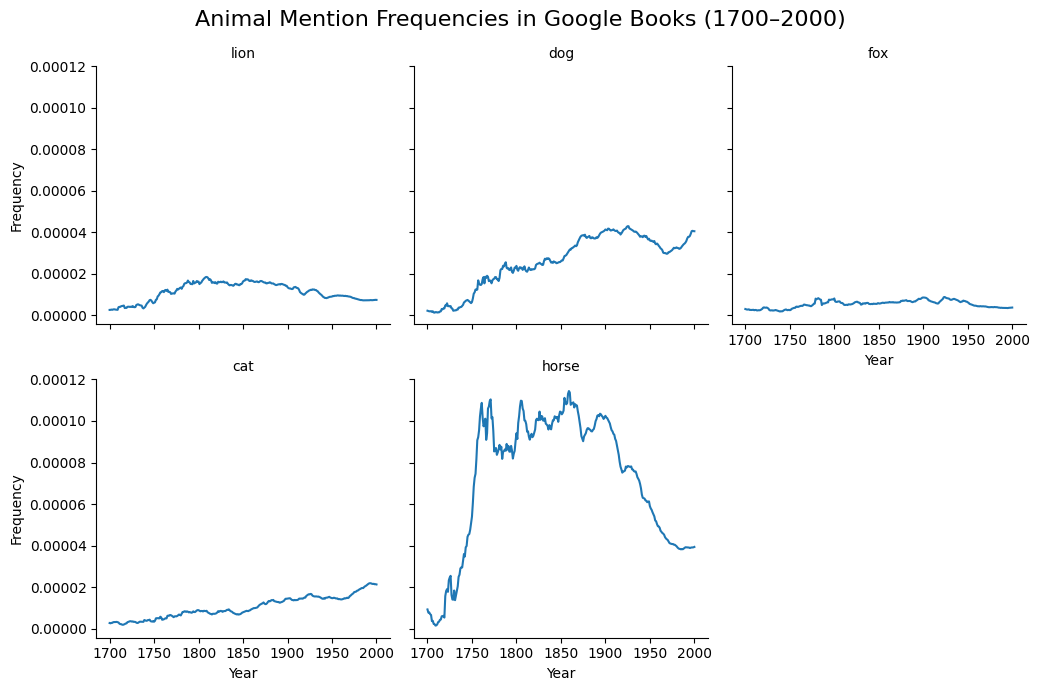

In [6]:


def plot_facet_ngram_counts(df_all, animals_to_plot=None, normalize=False, log_scale=False, n_cols=3):
    """
    Plot time series of animal Ngram frequencies using seaborn facets (one plot per animal).
    Shared y-axis allows cross-animal comparison.
    """
    animals = animals_to_plot or [col for col in df_all.columns if col != "year"]

    # Reshape to long format: ['year', 'animal', 'frequency']
    df_long = df_all.melt(id_vars='year', value_vars=animals, var_name='animal', value_name='frequency')

    # Normalize if requested
    if normalize:
        df_long['frequency'] = df_long.groupby('animal')['frequency'].transform(
            lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))

    # Set up FacetGrid
    g = sns.FacetGrid(df_long, col='animal', col_wrap=n_cols, sharex=True, sharey=True, height=3.5)
    g.map(sns.lineplot, 'year', 'frequency')

    # Axis formatting
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Year", "Frequency" if not log_scale else "Log Frequency")
    if log_scale:
        for ax in g.axes.flat:
            ax.set_yscale("log")

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Animal Mention Frequencies in Google Books (1700–2000)", fontsize=16)
    plt.show()


plot_facet_ngram_counts(df_all, animals_to_plot=["lion", "dog", "fox", "cat", "horse"], normalize=False)


In [7]:
df_all.to_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/animal_ngrams.csv', index=False)

# Creating a database of title, year, source, file_path

In [ ]:
animal_lemmas = {nlp(animal.lower())[0].lemma_ for animal in animals}

def locate_animals_in_text(text, list_of_animals):
    # Pre-lemmatize animal list just once
    animal_lemmas = {nlp(animal.lower())[0].lemma_: animal for animal in list_of_animals}
    animal_to_sentences = defaultdict(list)
    doc = nlp(text)
    for sent in doc.sents:
        lemmas_in_sent = {token.lemma_.lower() for token in sent}
        for lemma, orig_animal in animal_lemmas.items():
            if lemma in lemmas_in_sent:
                animal_to_sentences[orig_animal].append(sent.text)
    return animal_to_sentences


def fetch_gutenberg_books(start_id, num_books, list_of_animals, path, max_sentences_per_animal=3):
    for book_id in range(start_id, start_id + num_books):
        try:
            url = f"https://www.gutenberg.org/files/{book_id}/{book_id}.txt"
            resp = requests.get(url, timeout=5)
            if resp.status_code != 200:
                continue

            text = resp.text.lower()
            text = text[:int(len(text) * 0.1)]  # use first 10% for speed

            # Extract metadata
            title, year = None, None
            for line in text.splitlines()[:60]:
                if title is None and line.startswith("title:"):
                    title = line.split("title:",1)[1].strip()
                elif year is None and line.startswith("release date:"):
                    m = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", line)
                    if m:
                        year = int(m.group())
                if title and year:
                    break
            title = title or f"Book {book_id}"

            if year is not None:
                animal_to_sentences = locate_animals_in_text(text, list_of_animals)
                rows = []
                for animal, sentences in animal_to_sentences.items():
                    for sent in sentences[:max_sentences_per_animal]:
                        rows.append({
                            "id": book_id,
                            "title": title,
                            "year": year,
                            "animal": animal,
                            "text": sent,
                        })
                if rows:
                    pd.DataFrame(rows).to_csv(path, mode='a', header=False, index=False)
            # Explicit cleanup
            del text, animal_to_sentences
            gc.collect()
        except Exception as e:
            print(f"⚠️ Failed to fetch book {book_id}: {e}")
            continue

In [ ]:
path = '/content/drive/MyDrive/HW docs/5th Year/Micki/raw_text_data/gutenberg/gutenberg_books_new.csv'

In [ ]:
from tqdm import tqdm
import gc

batches = 100

for i in tqdm(range(1, 101)):
    start_id = i * batches
    fetch_gutenberg_books(start_id, batches, animals, path)
    gc.collect()


  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
gut_final_df = pd.read_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/raw_text_data/gutenberg/gutenberg_books_new.csv')
gut_final_df.shape

(16273, 5)

In [ ]:
def fetch_archive_books(batch_size, page=1, list_of_animals=None, max_sentences_per_animal=3):
    """
    Fetch and process English-language fiction texts from Internet Archive,
    filtering for sentences that contain known animals. Returns a list of
    dicts: {id, title, year, animal, text}.
    """

    # Build search query
    base_q = 'mediatype:"texts" AND language:"English"'
    q = base_q  # can add genres here if needed

    # Step 1: Search for metadata
    SEARCH_URL = "https://archive.org/advancedsearch.php"
    params = {
        "q":      q,
        "fl[]":   ["identifier", "title", "date"],
        "rows":   batch_size,
        "page":   page,
        "sort[]": "identifierSorter asc",
        "output": "json",
    }
    resp = requests.get(SEARCH_URL, params=params, timeout=(5, 30))
    resp.raise_for_status()
    docs = resp.json()["response"]["docs"]

    rows = []

    for doc in docs:
        try:
            identifier = doc["identifier"]
            meta = requests.get(f"https://archive.org/metadata/{identifier}", timeout=(5, 30)).json()
            md = meta.get("metadata", {})

            title = doc.get("title") or md.get("title") or identifier
            if isinstance(title, list):
                title = title[0].strip()

            # Extract year from metadata
            year = None
            for key in ("year", "publicdate", "date", "originaldate", "copyrightdate"):
                val = md.get(key)
                if val:
                    val = val[0] if isinstance(val, list) else val
                    match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", str(val))
                    if match:
                        year = int(match.group())
                        break
            if year is None:
                for v in md.values():
                    items = v if isinstance(v, list) else [v]
                    for x in items:
                        match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", str(x))
                        if match:
                            year = int(match.group())
                            break
                    if year: break

            # Get plain .txt file
            files = meta.get("files", [])
            txts = [f["name"] for f in files if f["name"].lower().endswith(".txt") and not f["name"].lower().endswith(".gz")]
            if not txts:
                print(f"⚠️ No .txt for {identifier}, skipping")
                continue

            # Download and process text
            text_url = f"https://archive.org/download/{identifier}/{txts[0]}"
            text = requests.get(text_url, timeout=(5, 30)).text.lower()
            text = text[:int(len(text) * 0.1)]  # only keep first 10% of text

            if year is not None:
                animal_to_sentences = locate_animals_in_text(text, list_of_animals)
                for animal, sentences in animal_to_sentences.items():
                    for sent in sentences[:max_sentences_per_animal]:
                        rows.append({
                            "id": identifier,
                            "title": title,
                            "year": year,
                            "animal": animal,
                            "text": sent,
                        })

            del text, animal_to_sentences
            gc.collect()

        except Exception as e:
            print(f"⚠️ Failed to process book {identifier}: {e}")
            continue

    return rows

In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
all_books = []
for p in tqdm(range(1, 200)):  # for example, 5 pages × 500 = 2,500 books
    batch = fetch_archive_books(batch_size=10, page=p, list_of_animals=animals)
    all_books.extend(batch)


In [ ]:
all_books.to_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/raw_text_data/InternetArchive/archive_animals.csv', index=False)

In [ ]:
df_archive = pd.read_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/raw_text_data/InternetArchive/archive_animals.csv')

# sentiment analysis

In [10]:
!pip install transformers torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from tqdm import tqdm
tqdm.pandas()  # <- registers .progress_apply

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [11]:
# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # ensure no dropout

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def get_sentiment_score(text: str, max_chars: int = 300) -> float:
    try:
        text = text[:max_chars]  # Truncate long "sentences"
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().tolist()
        score = -1 * probs[0] + probs[2]
        return round(score, 3)
    except Exception as e:
        print(f"Error processing: {text[:30]}... | {e}")
        return None


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
df = df[df["sentence"].str.len() < 500]
df["sentiment_score"] = df["sentence"].progress_apply(lambda x: get_sentiment_score(x, max_chars=500))


In [ ]:
df.to_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/df_big_sentiment.csv', index=False)

# SBERT

In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm
import torch
import pandas as pd
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
print(torch.cuda.is_available())  # Should be True

# Load pretrained SBERT model (fast + effective)
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

False


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/df_sentiment_new.csv')
df

title       identifier  year animal  \
0      Lilith  /works/OL15437W  1895  raven   
1      Lilith  /works/OL15437W  1895  raven   
2      Lilith  /works/OL15437W  1895  raven   
3      Lilith  /works/OL15437W  1895    cat   
4      Lilith  /works/OL15437W  1895    cat   
...       ...              ...   ...    ...   
32297   kazan            10084  2003   wolf   
32298   kazan            10084  2003    dog   
32299   kazan            10084  2003    dog   
32300   kazan            10084  2003    dog   
32301   kazan            10084  2003    cat   

                                                sentence  sentiment_score  
0      THE  RAVEN \n\n• \n\n• \n\n• \n\n• \n\n• \n\n1...           -0.087  
1      Being  short-sighted,  I stepped  closer  to  ...            0.030  
2      Instinctively \nthen,  as  to  the  only  livi...            0.220  
3                            THE  PERSIAN  CAT  . . \n\n           -0.001  
4      A wild-looking  Httle  black  cat  jumped  on ...            0.144  
...                                                  ...              ...  
32297  he lay on his belly in the deep snow and\r\nsh...           -0.447  
32298  he was called kazan, the wild dog,\r\nbecause ...            0.438  
32299  "and you are kazan--dear old kazan, my kazan, ...            0.404  
32300  he, too, knelt down beside them, and put his a...            0.164  
32301  thorpe's wife was sleeping, and as quietly as ...           -0.056  

[32302 rows x 6 columns]

In [ ]:
# Get sentence list
sentences = df['sentence'].tolist()

# Compute embeddings for all sentences
sentence_embeddings = model.encode(sentences, show_progress_bar=True)

In [ ]:
# Combine into a new DataFrame
emb_df = pd.DataFrame(sentence_embeddings)  # shape: [num_sentences, embedding_dim]
df_sbert = pd.concat([df.reset_index(drop=True), emb_df], axis=1)
df_sbert.head()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import umap.umap_ as umap
from sklearn.cluster import KMeans

df_sbert = pd.read_csv("/content/drive/MyDrive/HW docs/5th Year/Micki/df_sbert.csv")

/tmp/ipython-input-2522594896.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sbert = pd.read_csv("/content/drive/MyDrive/HW docs/5th Year/Micki/df_sbert.csv")


In [ ]:
df_sbert.columns

Index(['title', 'identifier', 'year', 'animal', 'sentence', 'sentiment_score',
       '0', '1', '2', '3',
       ...
       '375', '376', '377', '378', '379', '380', '381', '382', '383',
       'decade'],
      dtype='object', length=391)

In [ ]:
embedding_dim = 384

df_sbert['decade'] = df_sbert['year'].astype(int) // 10 * 10

embedding_cols = [str(i) for i in list(range(embedding_dim))]  # e.g., 0–383 if using SBERT base
animal_decade_vecs = df_sbert.groupby(['animal', 'decade'])[embedding_cols].mean()

# animal_decade_vecs = df_sbert.groupby(['animal', 'decade']).mean(numeric_only=True)
animal_vecs = df_sbert.groupby('animal').mean(numeric_only=True)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-3196160537.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


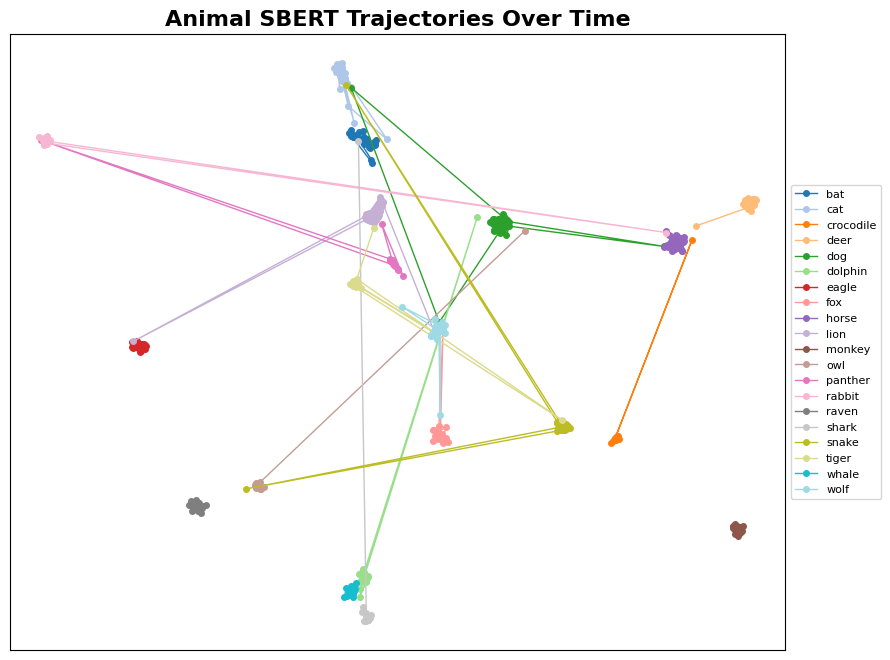

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.animation as animation

# Recreate embeddings, labels, and index from previous context
# Assuming df_sbert, animal_decade_vecs already exist

# Setup
X = animal_decade_vecs.values
index = animal_decade_vecs.index
animals = sorted(set(a for a, _ in index))
decades = sorted(set(d for _, d in index))

# UMAP projection
reducer = umap.UMAP(random_state=42)
X_2d = reducer.fit_transform(X)

# Build a mapping from (animal, decade) to 2D coords
animal_decade_to_point = {
    (animal, decade): point
    for (animal, decade), point in zip(index, X_2d)
}

# Color map
cmap = get_cmap("tab20")
animal_to_color = {animal: cmap(i % 20) for i, animal in enumerate(animals)}

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
scatters = {}
trails = {}

def init():
    ax.set_title("Animal SBERT Trajectories Over Time", fontsize=16, weight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1)
    ax.set_ylim(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1)
    return []

def update(frame):
    ax.clear()
    init()
    for animal in animals:
        # Collect points up to current frame
        past_points = [
            animal_decade_to_point[(animal, d)]
            for d in decades[:frame+1]
            if (animal, d) in animal_decade_to_point
        ]
        past_points = np.array(past_points)
        if len(past_points) > 0:
            ax.plot(past_points[:, 0], past_points[:, 1], '-o', label=animal,
                    color=animal_to_color[animal], markersize=4, linewidth=1)
    ax.legend(fontsize=8, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(f"SBERT Trajectories by Decade: {decades[frame]}", fontsize=14)
    return []

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(decades), init_func=init, blit=False, repeat=False
)

# Save animation as MP4 (or can display in notebook if needed)
from IPython.display import HTML
html_anim = HTML(ani.to_jshtml())
html_anim


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


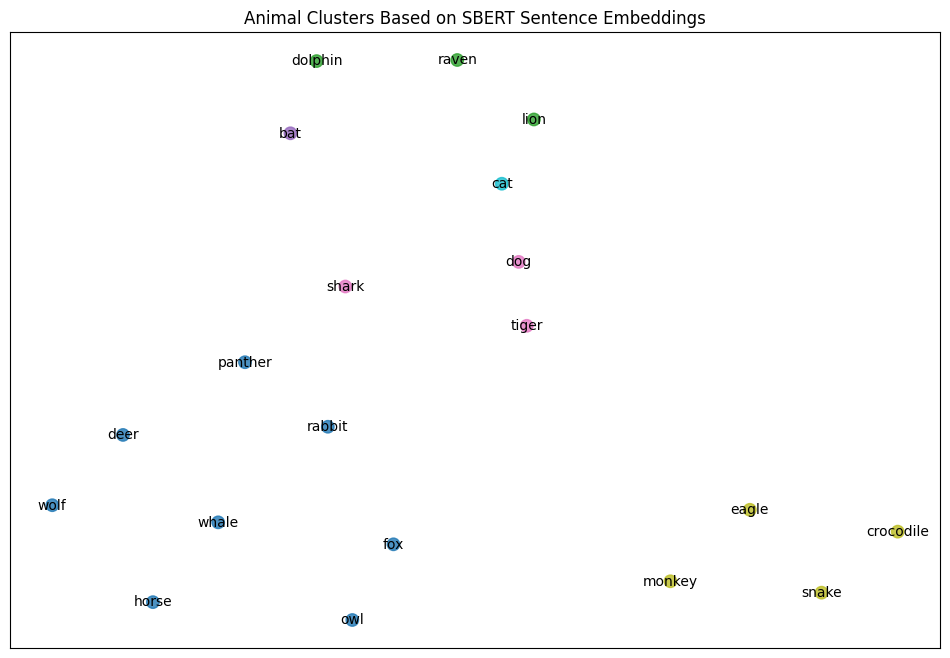

In [ ]:


X = animal_vecs.values
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X)


reducer = umap.UMAP(random_state=42)
X_2d = reducer.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=80, alpha=0.8)

# annotate
for i, name in enumerate(animal_vecs.index):
    plt.text(X_2d[i, 0], X_2d[i, 1], name, ha='center', va='center', fontsize=10)

plt.title("Animal Clusters Based on SBERT Sentence Embeddings")
plt.xticks([])
plt.yticks([])
plt.show()


# Ploting stuff

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HW docs/5th Year/Micki/df_sentiment_new.csv')
df

title       identifier  year animal  \
0      Lilith  /works/OL15437W  1895  raven   
1      Lilith  /works/OL15437W  1895  raven   
2      Lilith  /works/OL15437W  1895  raven   
3      Lilith  /works/OL15437W  1895    cat   
4      Lilith  /works/OL15437W  1895    cat   
...       ...              ...   ...    ...   
32297   kazan            10084  2003   wolf   
32298   kazan            10084  2003    dog   
32299   kazan            10084  2003    dog   
32300   kazan            10084  2003    dog   
32301   kazan            10084  2003    cat   

                                                sentence  sentiment_score  
0      THE  RAVEN \n\n• \n\n• \n\n• \n\n• \n\n• \n\n1...           -0.087  
1      Being  short-sighted,  I stepped  closer  to  ...            0.030  
2      Instinctively \nthen,  as  to  the  only  livi...            0.220  
3                            THE  PERSIAN  CAT  . . \n\n           -0.001  
4      A wild-looking  Httle  black  cat  jumped  on ...            0.144  
...                                                  ...              ...  
32297  he lay on his belly in the deep snow and\r\nsh...           -0.447  
32298  he was called kazan, the wild dog,\r\nbecause ...            0.438  
32299  "and you are kazan--dear old kazan, my kazan, ...            0.404  
32300  he, too, knelt down beside them, and put his a...            0.164  
32301  thorpe's wife was sleeping, and as quietly as ...           -0.056  

[32302 rows x 6 columns]

In [ ]:
# Group by book and count the number of sentences
sentences_per_book = df.groupby('identifier')['sentence'].count()

# Calculate the average and standard deviation
avg_sentences_per_book = sentences_per_book.mean()
std_sentences_per_book = sentences_per_book.std()

print(f"Average sentences per book: {avg_sentences_per_book:.1f}")
print(f"Standard deviation of sentences per book: {std_sentences_per_book:.1f}")

Average sentences per book: 4.4
Standard deviation of sentences per book: 3.8


### EDA

In [ ]:
# Assuming df is already loaded
df['sentence_length'] = df['sentence'].astype(str).apply(len)

summary_df = df.groupby('animal').agg(
    avg_sentence_length=('sentence_length', 'mean'),
    num_books=('identifier', 'nunique'),
    num_sentences=('sentence', 'count'),
    first_appearance=('year', 'min'),
    last_appearance=('year', 'max')
).reset_index()
summary_df['avg_sentence_length'] = summary_df['avg_sentence_length'].round(1)
summary_df = summary_df.sort_values(by='num_books', ascending=False)
summary_df


animal  avg_sentence_length  num_books  num_sentences  \
8       horse                191.9       4333           8814   
4         dog                174.7       3429           6229   
1         cat                172.2       1997           3123   
9        lion                186.3       1421           2050   
19       wolf                179.9        954           1552   
7         fox                179.0        907           1421   
6       eagle                196.7        776           1061   
16      snake                177.3        732           1081   
3        deer                204.4        697           1100   
13     rabbit                181.9        697           1108   
0         bat                180.1        593            818   
10     monkey                177.6        537            791   
17      tiger                186.5        508            718   
11        owl                185.6        487            715   
14      raven                189.3        336            435   
18      whale                196.1        281            415   
15      shark                188.6        191            274   
12    panther                186.8        184            251   
2   crocodile                198.5        145            204   
5     dolphin                188.6        100            142   

    first_appearance  last_appearance  
8               1000             2021  
4               1000             2021  
1               1489             2017  
9               1000             2013  
19              1000             2017  
7               1489             2021  
6               1489             2015  
16              1545             2015  
3               1505             2011  
13              1773             2017  
0               1489             2013  
10              1675             2012  
17              1523             2021  
11              1734             2010  
14              1523             2009  
18              1627             2009  
15              1000             2009  
12              1600             2009  
2               1766             2009  
5               1000             2007

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


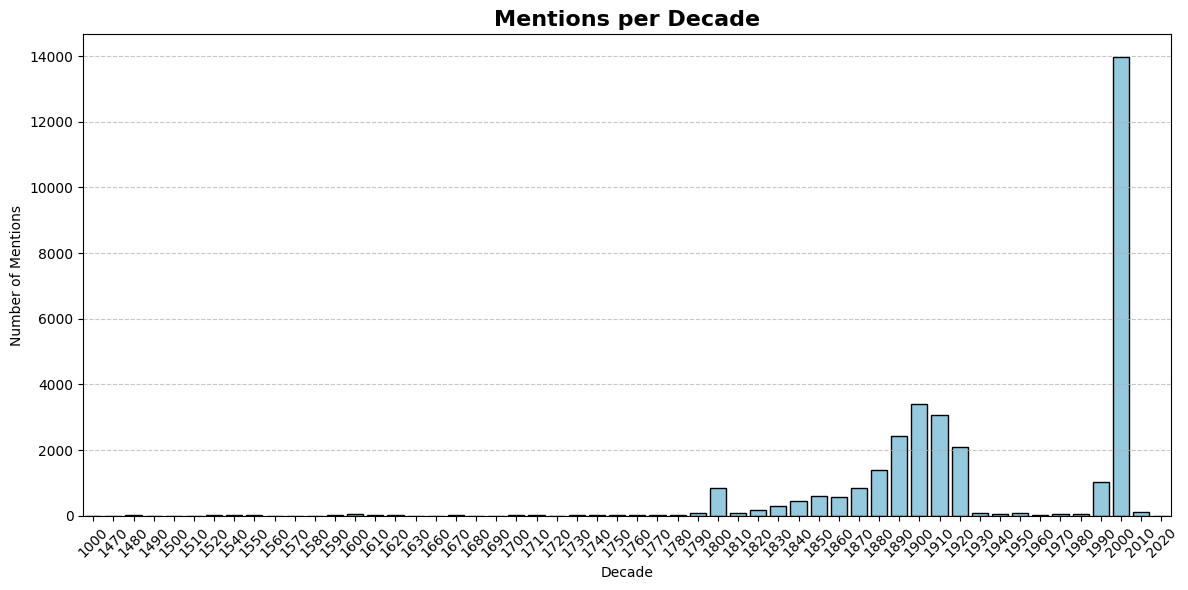

In [ ]:
df["year"] = df["year"].astype(int)

# Aggregate mentions per decade
df["decade"] = (df["year"] // 10) * 10
mentions_per_decade = df.groupby("decade")["sentence"].count().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mentions_per_decade, x="decade", y="sentence", color="skyblue", edgecolor="black")

plt.title("Mentions per Decade", fontsize=16, weight="bold")
plt.xlabel("Decade")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### sentiment score plots

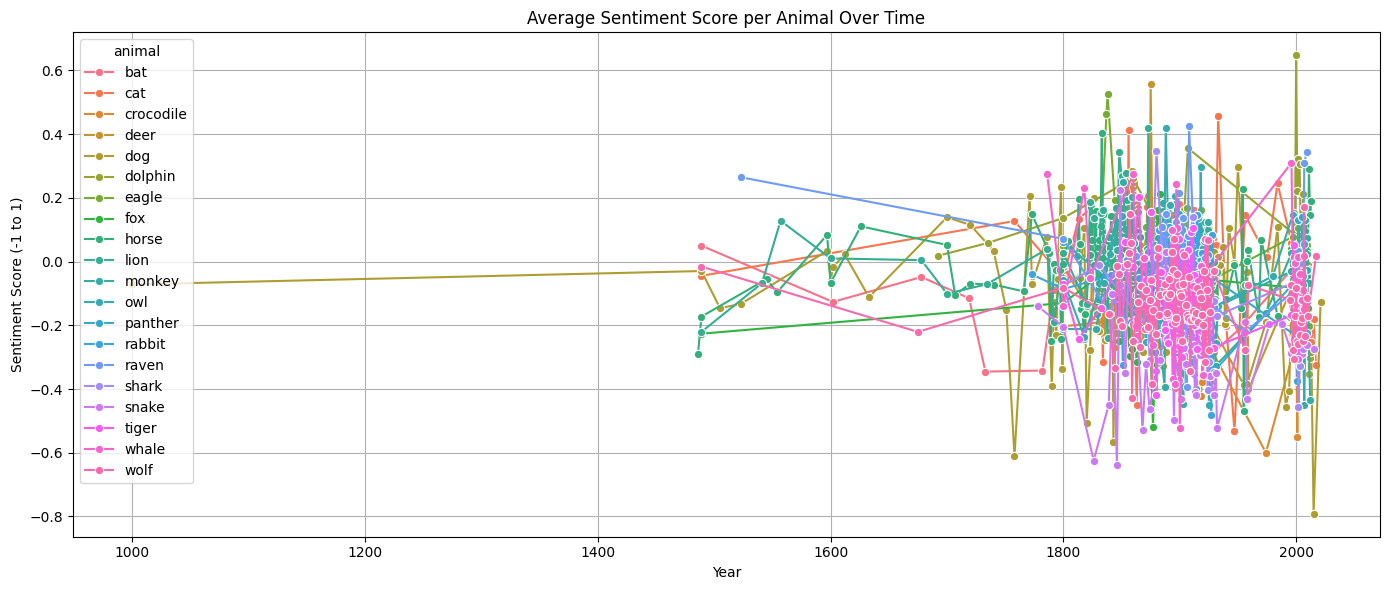

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Round years to decade (optional smoothing)
# df["decade"] = (df["year"] // 10) * 10

# Group and average
grouped = df.groupby(["animal", "year"]).agg(
    avg_score=("sentiment_score", "mean"),
    count=("sentiment_score", "count")
).reset_index()

# Filter out sparse years if needed
grouped = grouped[grouped["count"] >= 3]

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped, x="year", y="avg_score", hue="animal", marker="o")
plt.title("Average Sentiment Score per Animal Over Time")
plt.ylabel("Sentiment Score (-1 to 1)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


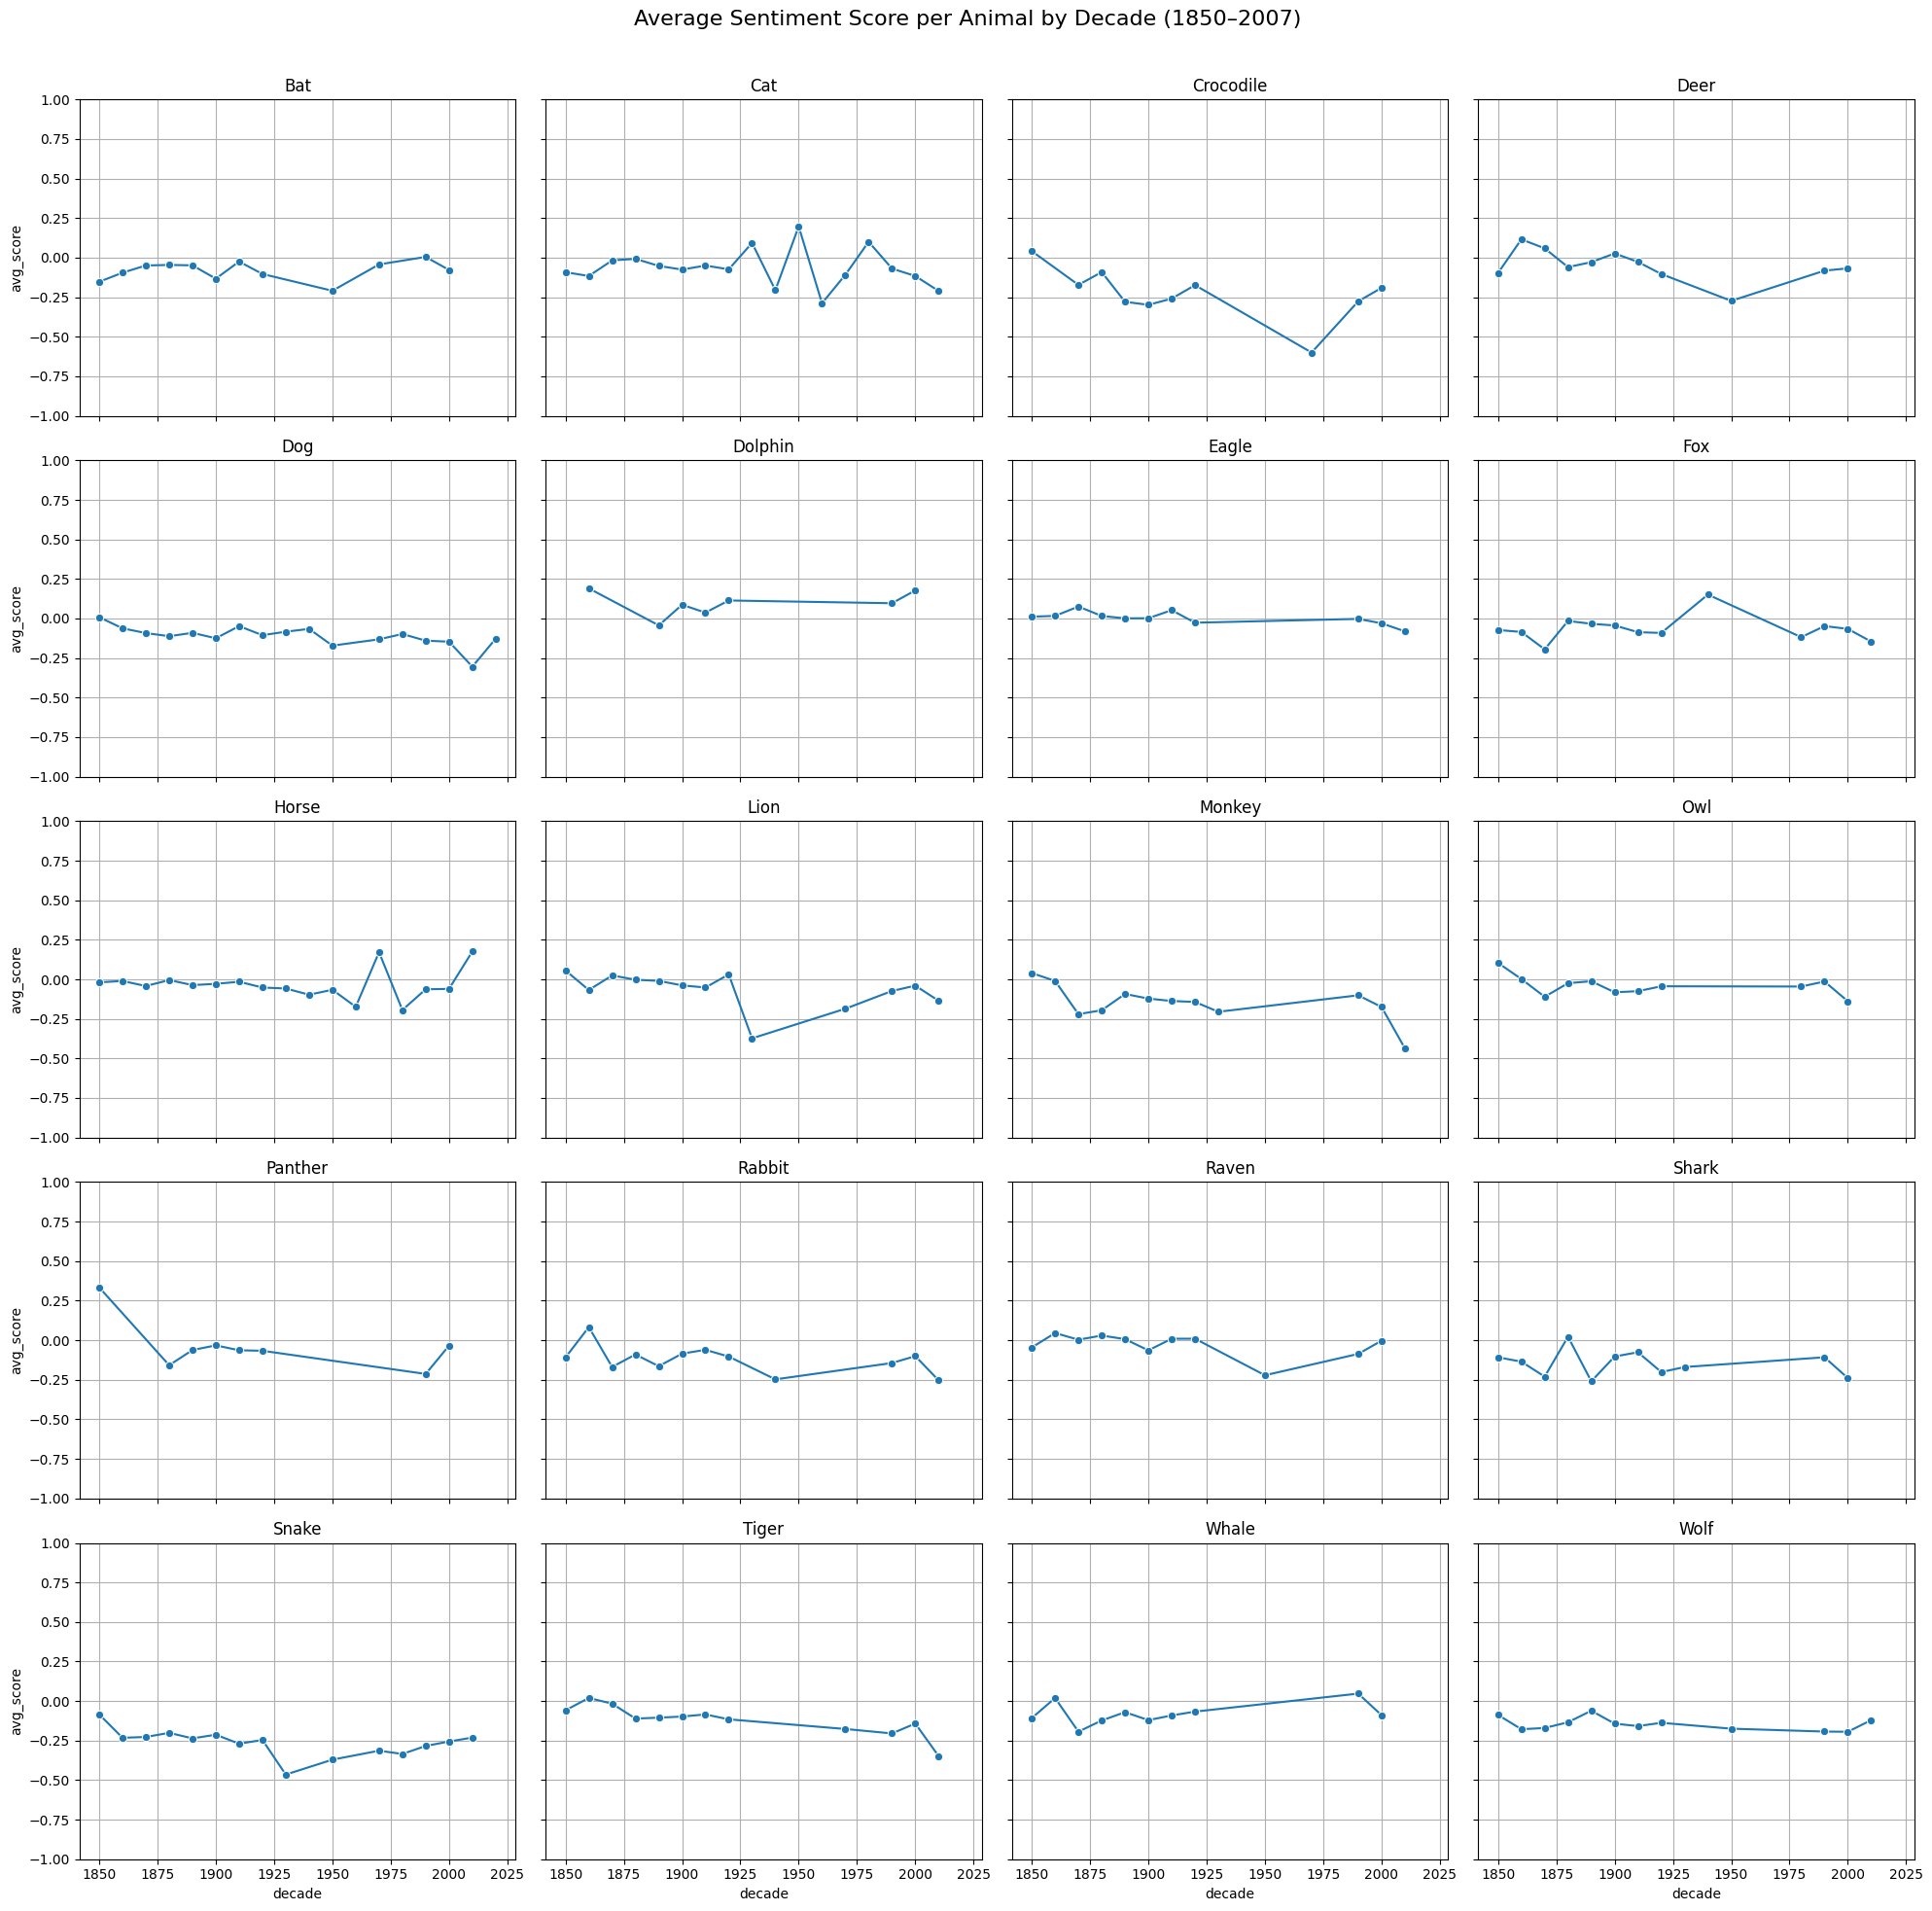

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# Filter to post-1850 and add 'decade' column
df_filtered = df[df['year'] >= 1850].copy()
df_filtered["decade"] = (df_filtered["year"] // 10) * 10

# Group by animal and decade
grouped = df_filtered.groupby(["animal", "decade"]).agg(
    avg_score=("sentiment_score", "mean"),
    count=("sentiment_score", "count")
).reset_index()

# Filter sparse entries
grouped = grouped[grouped["count"] >= 3]

# Unique animals
unique_animals = sorted(grouped["animal"].unique())
n_animals = len(unique_animals)

# Subplot grid layout
cols = 4
rows = math.ceil(n_animals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Plot per animal
for i, animal in enumerate(unique_animals):
    ax = axes[i]
    animal_data = grouped[grouped["animal"] == animal]
    sns.lineplot(data=animal_data, x="decade", y="avg_score", marker="o", ax=ax)
    ax.set_title(animal.capitalize())
    ax.set_ylim(-1, 1)
    ax.grid(True)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Average Sentiment Score per Animal by Decade (1850–2007)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


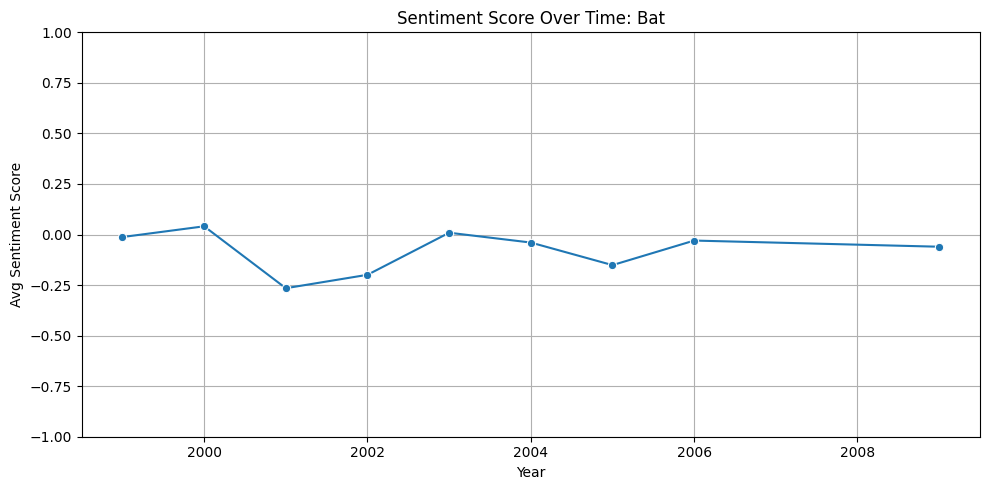

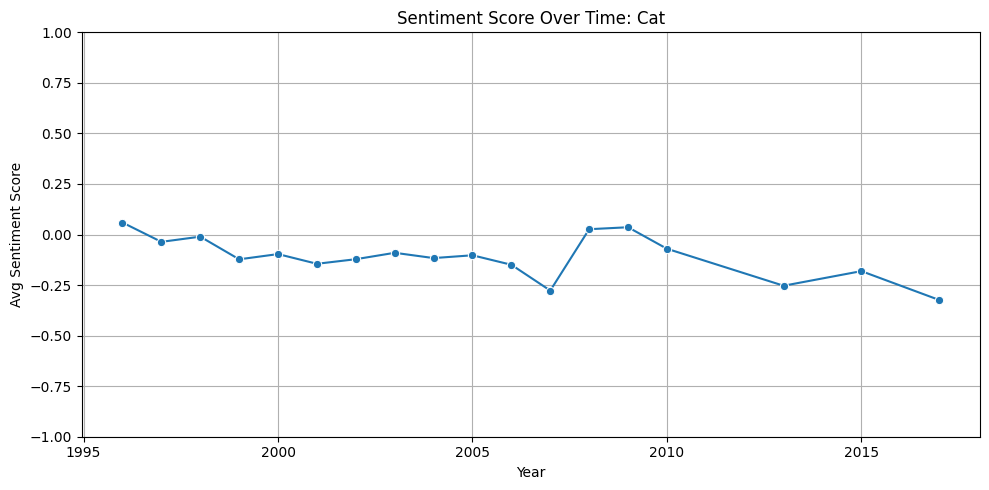

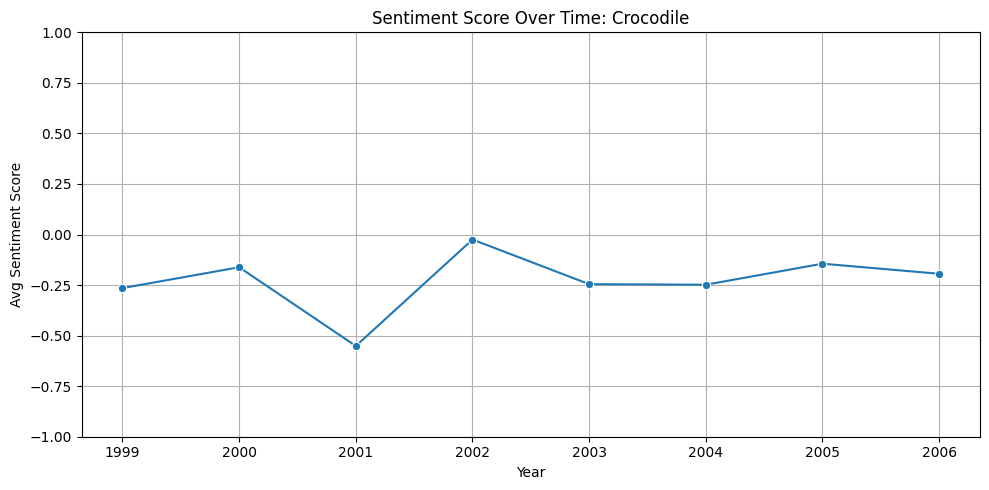

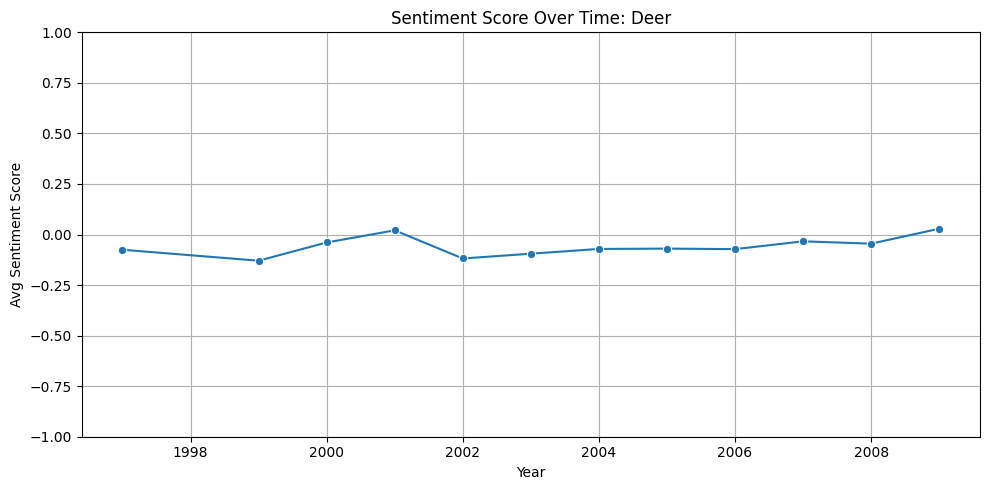

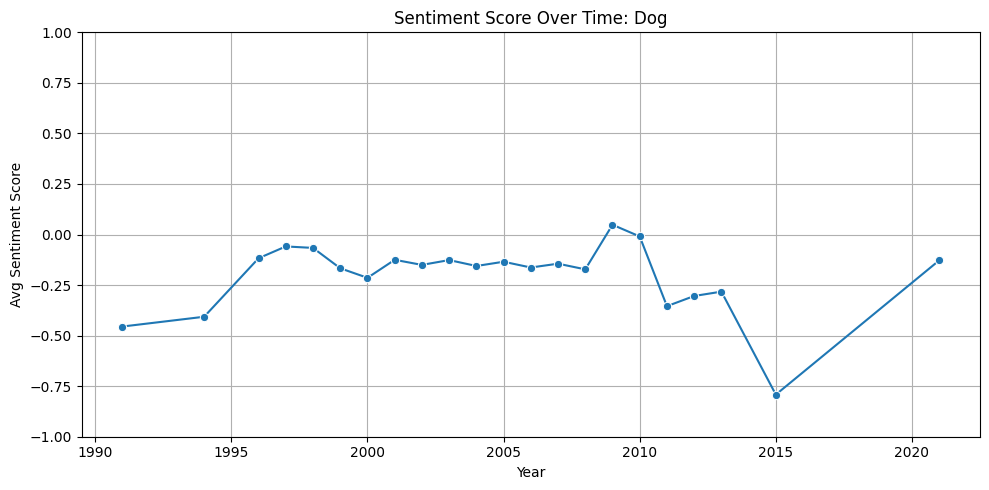

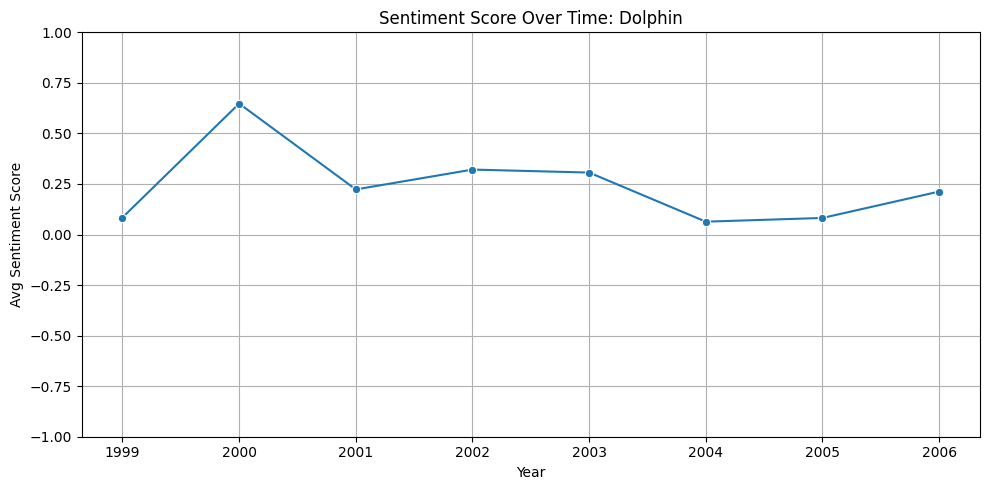

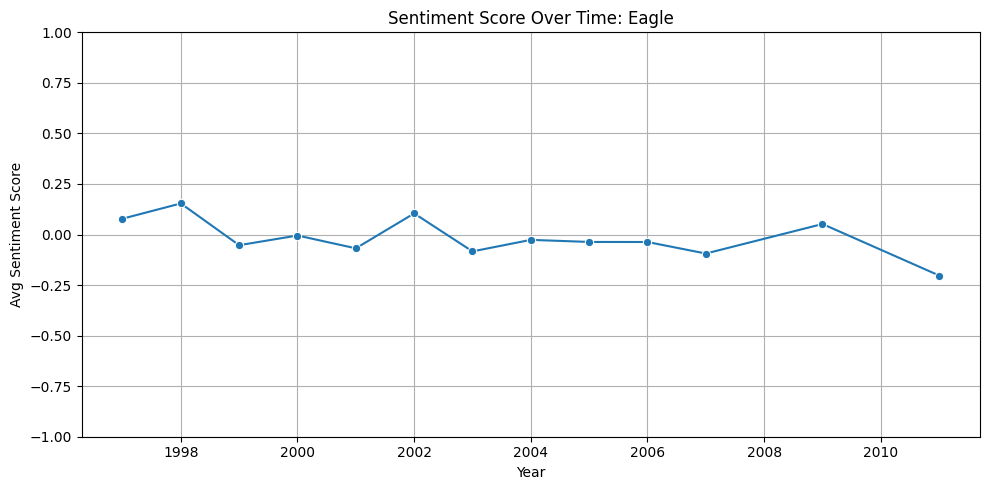

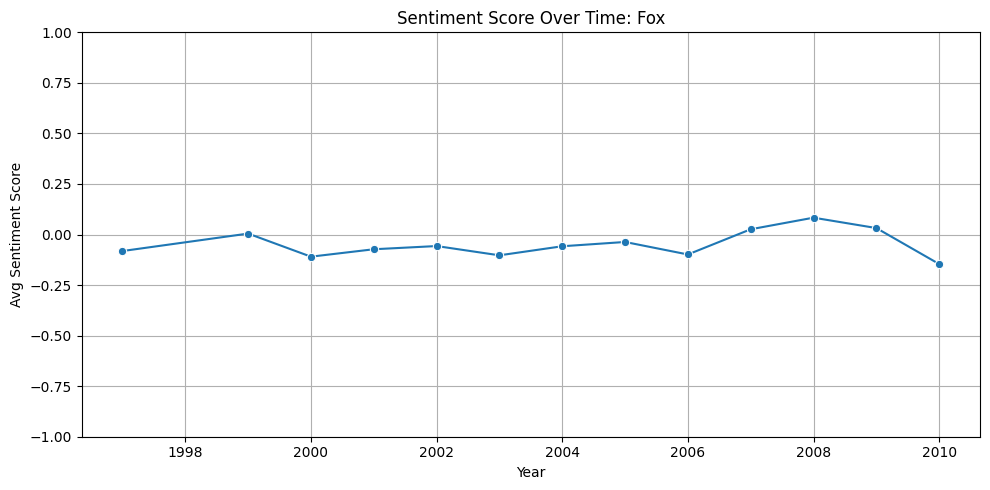

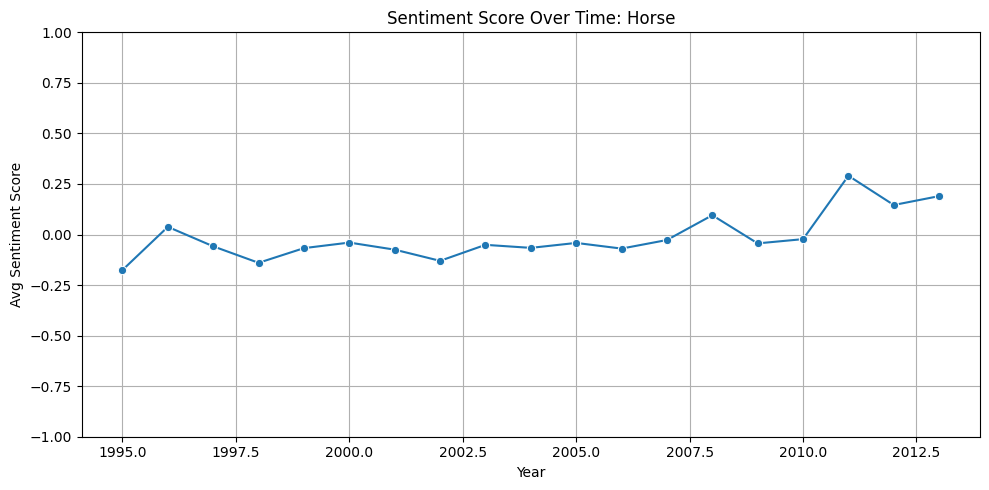

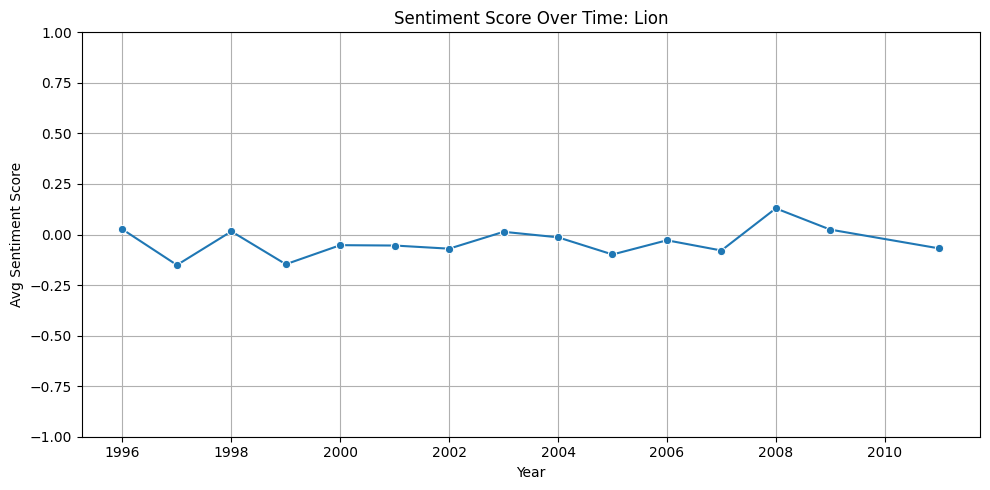

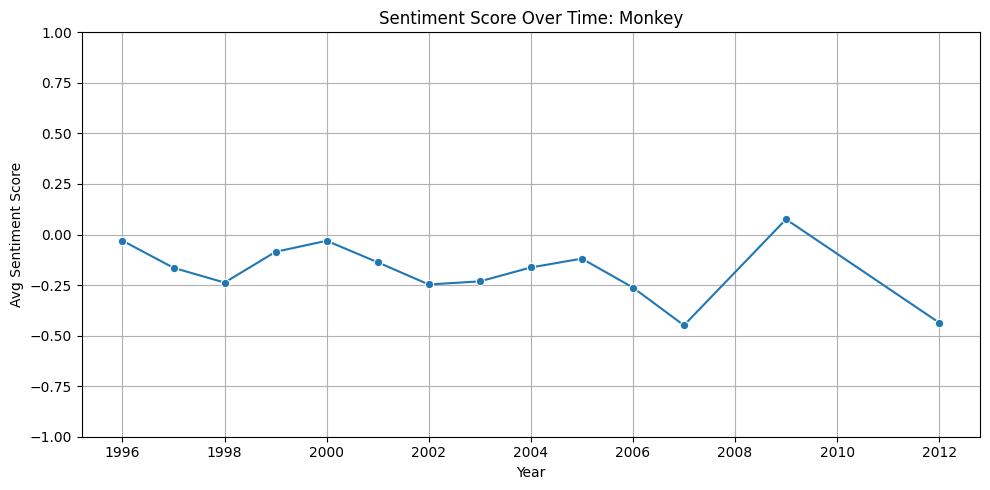

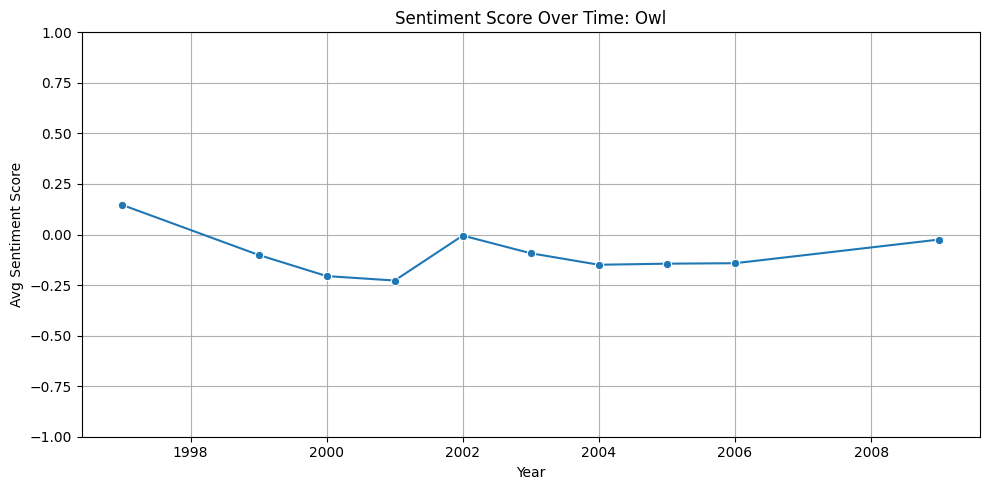

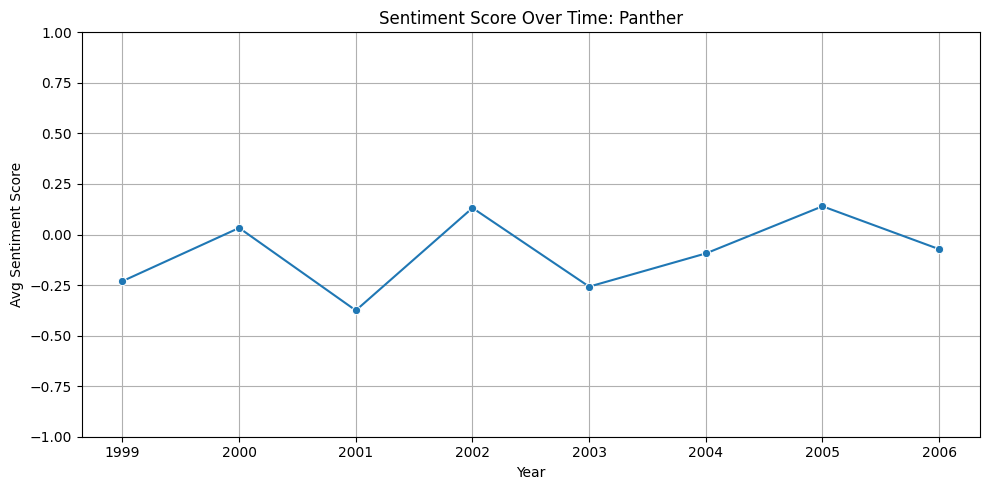

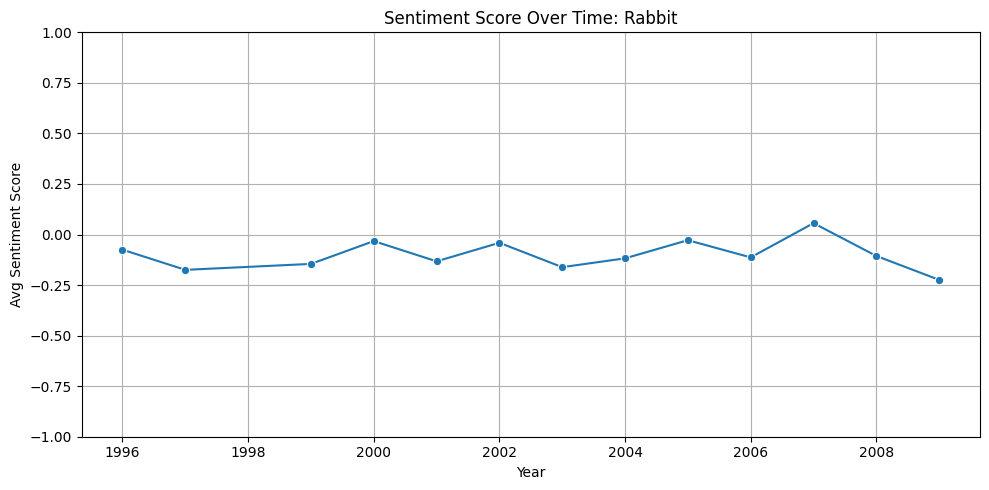

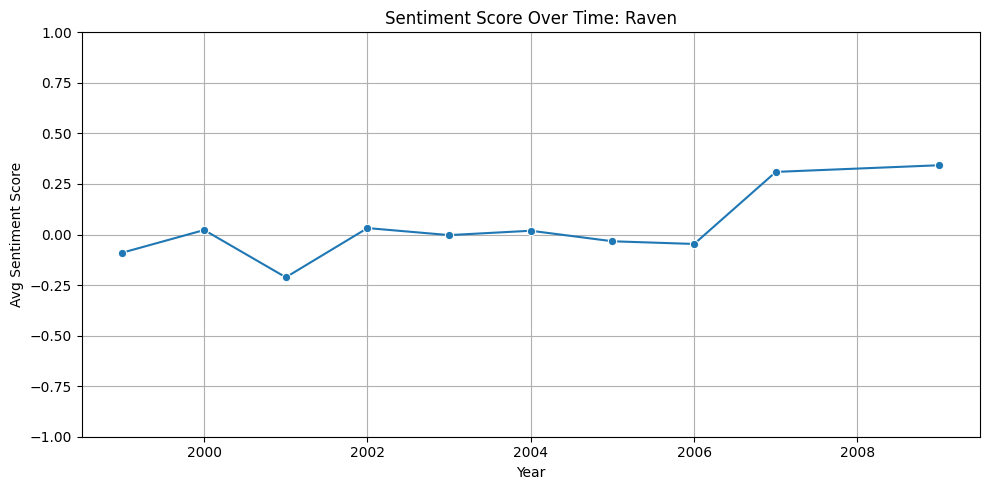

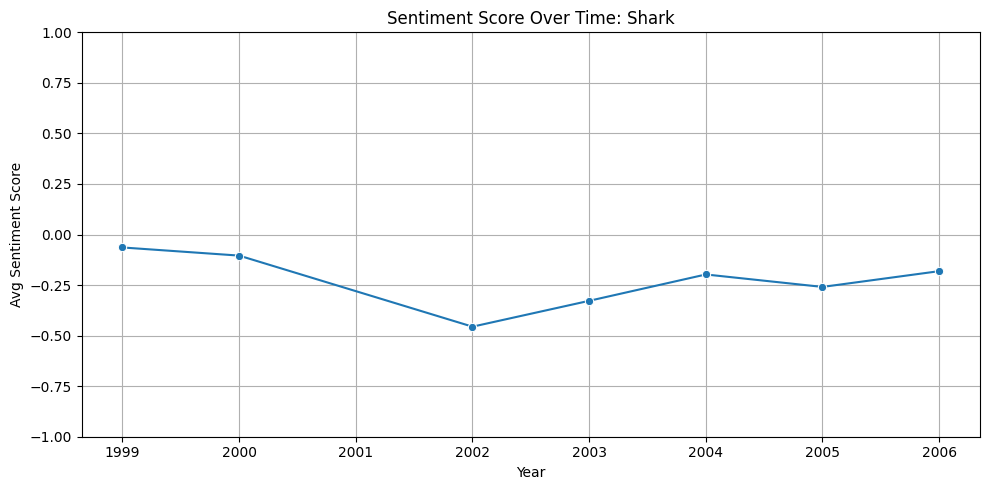

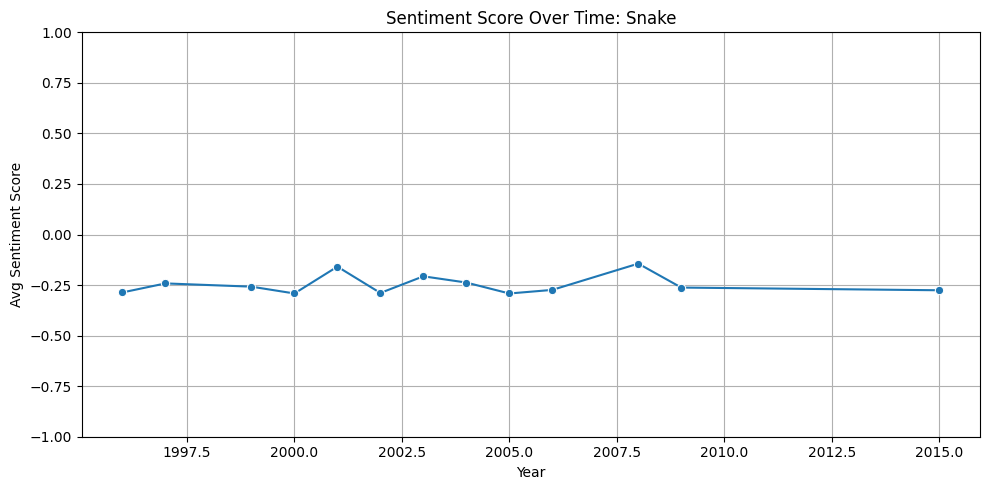

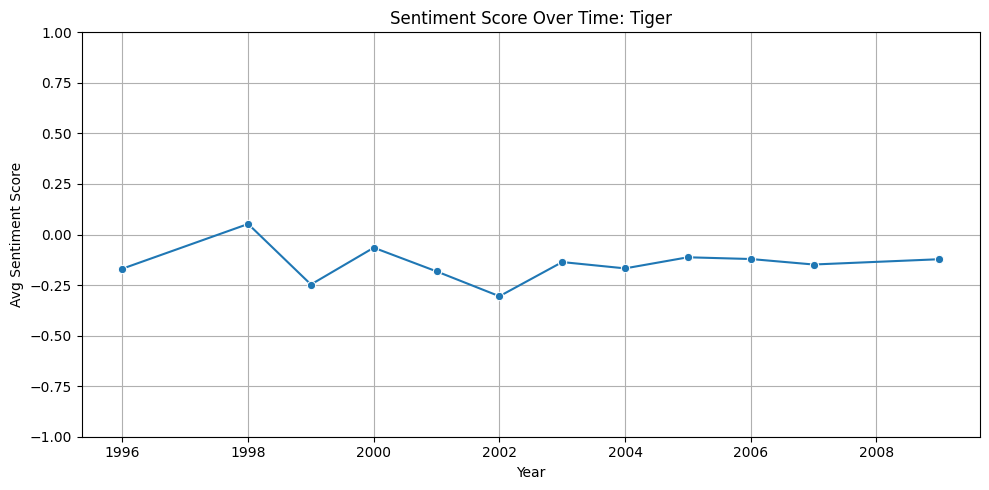

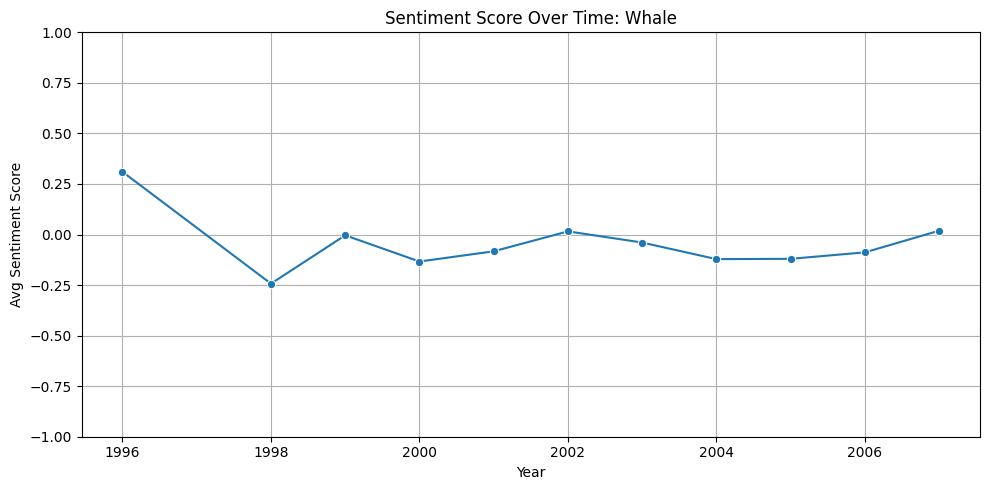

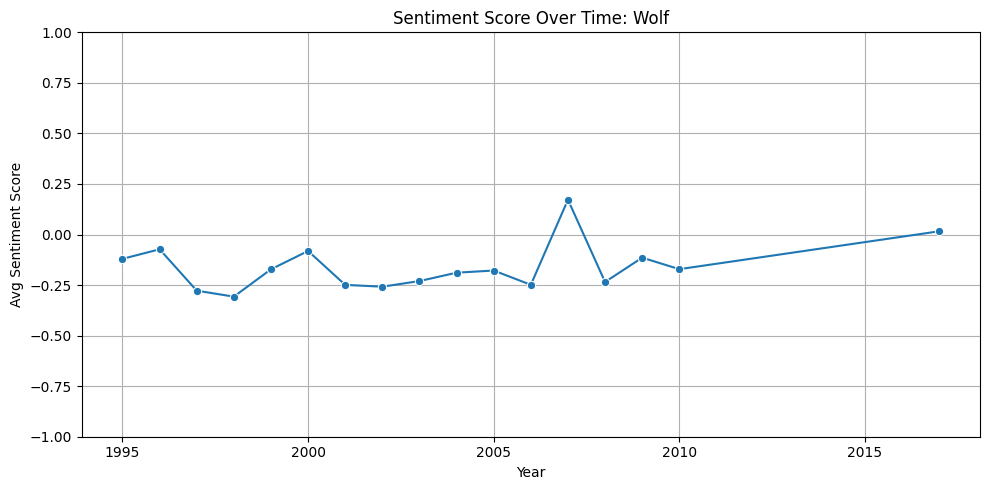

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_late_years = df[df['year']>=1990]
# Group and aggregate
grouped = df_late_years.groupby(["animal", "year"]).agg(
    avg_score=("sentiment_score", "mean"),
    count=("sentiment_score", "count")
).reset_index()

# Optional: filter out sparse data
grouped = grouped[grouped["count"] >= 3]

# Plot one figure per animal
unique_animals = grouped["animal"].unique()

for animal in unique_animals:
    animal_data = grouped[grouped["animal"] == animal]

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=animal_data, x="year", y="avg_score", marker="o")
    plt.title(f"Sentiment Score Over Time: {animal.capitalize()}")
    plt.xlabel("Year")
    plt.ylabel("Avg Sentiment Score")
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-753275988.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_scores, x="animal", y="avg_score", palette="coolwarm")


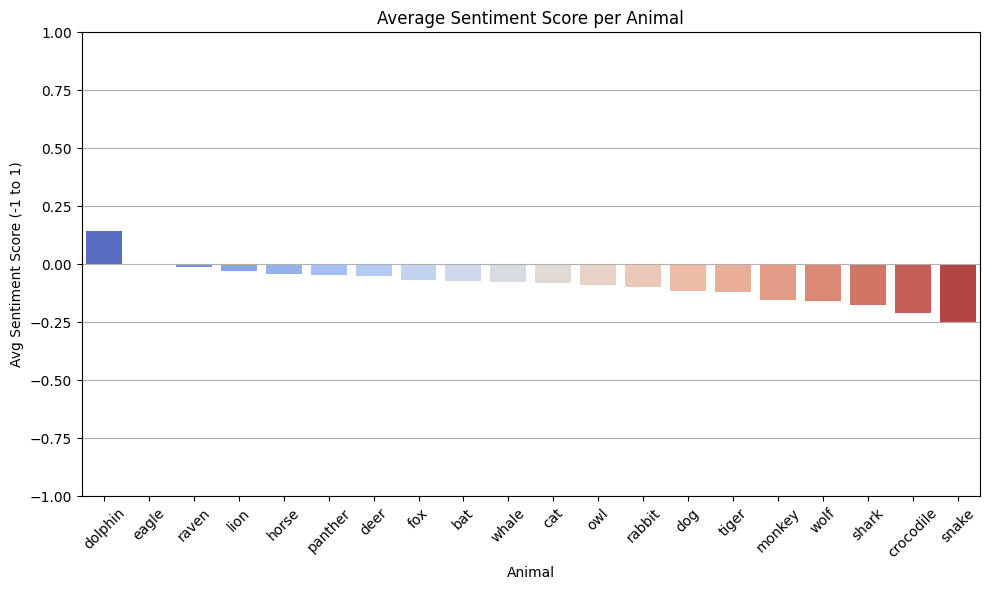

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by animal
avg_scores = df.groupby("animal").agg(
    avg_score=("sentiment_score", "mean"),
    count=("sentiment_score", "count")
).reset_index()

# Optional: filter animals with very low sentence counts
avg_scores = avg_scores[avg_scores["count"] >= 10]

# Sort by score (optional)
avg_scores = avg_scores.sort_values("avg_score", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_scores, x="animal", y="avg_score", palette="coolwarm")
plt.title("Average Sentiment Score per Animal")
plt.ylabel("Avg Sentiment Score (-1 to 1)")
plt.xlabel("Animal")
plt.ylim(-1, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


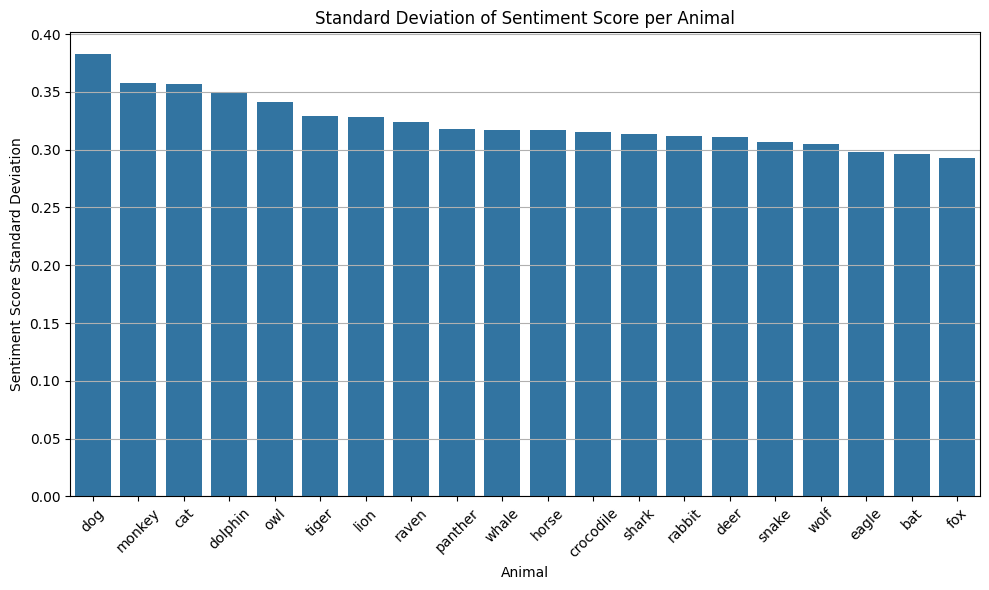

In [ ]:
# Group by animal and compute std and count
sentiment_std = df.groupby("animal").agg(
    std_score=("sentiment_score", "std"),
    count=("sentiment_score", "count")
).reset_index()

# Optional: filter low-count animals
sentiment_std = sentiment_std[sentiment_std["count"] >= 10]

# Sort by std (optional)
sentiment_std = sentiment_std.sort_values("std_score", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_std, x="animal", y="std_score")
plt.title("Standard Deviation of Sentiment Score per Animal")
plt.ylabel("Sentiment Score Standard Deviation")
plt.xlabel("Animal")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
df.head()

title       identifier  year animal  \
0  Lilith  /works/OL15437W  1895  raven   
1  Lilith  /works/OL15437W  1895  raven   
2  Lilith  /works/OL15437W  1895  raven   
3  Lilith  /works/OL15437W  1895    cat   
4  Lilith  /works/OL15437W  1895    cat   

                                            sentence  sentiment_score  
0  THE  RAVEN \n\n• \n\n• \n\n• \n\n• \n\n• \n\n1...           -0.087  
1  Being  short-sighted,  I stepped  closer  to  ...            0.030  
2  Instinctively \nthen,  as  to  the  only  livi...            0.220  
3                        THE  PERSIAN  CAT  . . \n\n           -0.001  
4  A wild-looking  Httle  black  cat  jumped  on ...            0.144

### general eda

/tmp/ipython-input-2744501306.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=book_counts_sorted, x='animal', y='unique_books', palette='viridis')


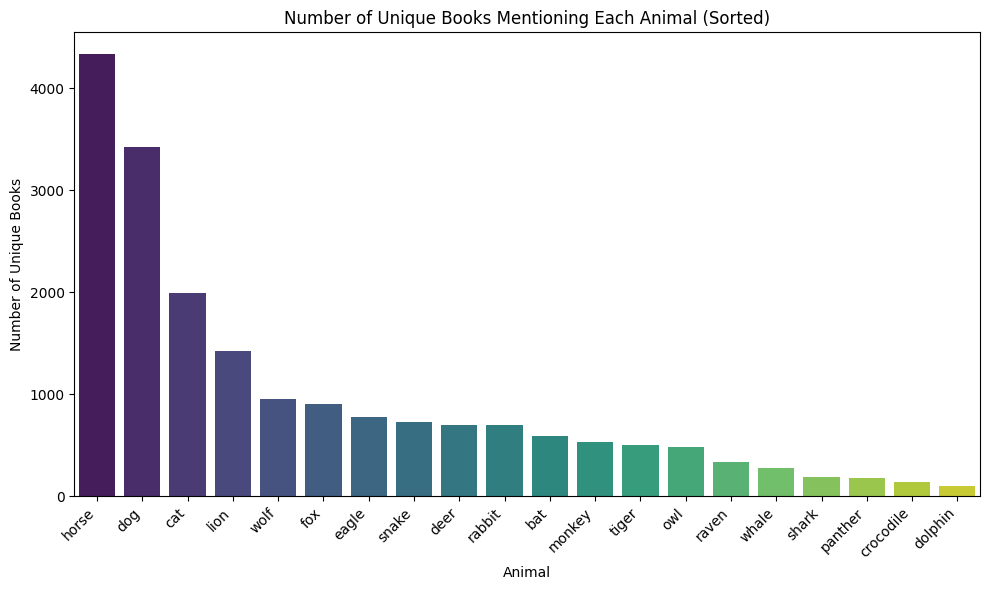

In [ ]:
import matplotlib.pyplot as plt
# Group by animal and get unique book counts
book_counts = df.groupby('animal')['identifier'].nunique().reset_index(name='unique_books')

# Sort by unique_books count in descending order
book_counts_sorted = book_counts.sort_values(by='unique_books', ascending=False)

# Plot the sorted data
plt.figure(figsize=(10, 6))
sns.barplot(data=book_counts_sorted, x='animal', y='unique_books', palette='viridis')
plt.title('Number of Unique Books Mentioning Each Animal (Sorted)')
plt.xlabel('Animal')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-965201754.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentence_counts, x="animal", y="count", palette="Blues_d")


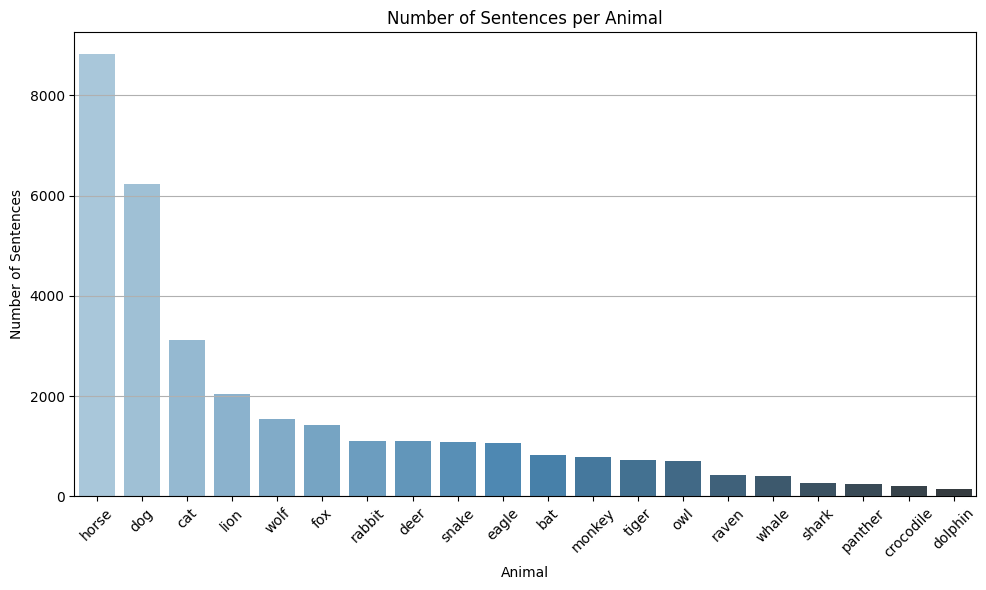

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentences per animal
sentence_counts = df["animal"].value_counts().reset_index()
sentence_counts.columns = ["animal", "count"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sentence_counts, x="animal", y="count", palette="Blues_d")

plt.title("Number of Sentences per Animal")
plt.xlabel("Animal")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
for animal in df["animal"].unique():
    sub = df[df["animal"] == animal]

    # Highest score
    highest_row = sub.loc[sub["sentiment_score"].idxmax()]
    print(f"\n🐾 {animal.upper()} — HIGHEST Sentiment")
    print(f"Score: {highest_row['sentiment_score']}")
    print(f"Sentence: {highest_row['sentence']}")
    print(f"Book: {highest_row['title']} ({highest_row['year']})")

    # Lowest score
    lowest_row = sub.loc[sub["sentiment_score"].idxmin()]
    print(f"\n🐾 {animal.upper()} — LOWEST Sentiment")
    print(f"Score: {lowest_row['sentiment_score']}")
    print(f"Sentence: {lowest_row['sentence']}")
    print(f"Book: {lowest_row['title']} ({lowest_row['year']})")
    print("-" * 80)



🐾 RAVEN — HIGHEST Sentiment
Score: 0.958
Sentence: She was a very beautiful woman, with finely cut 
features and raven black hair, which she wore in 
glossy smooth waves partly over her small ears.
Book: The mark of Cain (1917)

🐾 RAVEN — LOWEST Sentiment
Score: -0.929
Sentence: What dreadful man art thou, 
That like a raven, or the midnight owl, 
Com’st with this awful message from the 
grave ? 



Book: The Duchess of Padua (1905)
--------------------------------------------------------------------------------

🐾 CAT — HIGHEST Sentiment
Score: 0.968
Sentence: That  book  you 
wrote — about  cats,  why,  it's  wonderful!  
Book: The Story of Doctor Dolittle (1920)

🐾 CAT — LOWEST Sentiment
Score: -0.956
Sentence: "that woman," she declared, "is a detestable cat!
Book: the mischief maker (2005)
--------------------------------------------------------------------------------

🐾 HORSE — HIGHEST Sentiment
Score: 0.979
Sentence: i love my country, and i love horses.  
Book: the complete p

# trash and stuff i ended up giving up on

In [ ]:
# import requests
# import re

# def fetch_archive_books(batch_size, page=1, genres=None):
#     """
#     Fetch `batch_size` English-language fiction texts from IA,
#     using page `page` (1-indexed). Optionally pass `genres` as a
#     list of subject strings (e.g. ["Adventure fiction", "Fantasy fiction"]).
#     Returns a list of dicts: {id, title, year, text}.
#     """
#     # 1) Build your search query
#     base_q = 'mediatype:"texts" AND language:"English"'
#     if genres:
#         # escape any embedded quotes
#         esc = [g.replace('"','\\"') for g in genres]
#         subj_clause = " OR ".join(f'subject:"{g}"' for g in esc)
#         q = f'{base_q} AND ({subj_clause})'
#     else:
#         q = base_q

#     # 2) Hit Advanced Search for identifiers + basic info
#     SEARCH_URL = "https://archive.org/advancedsearch.php"
#     params = {
#         "q":      q,
#         "fl[]":   ["identifier","title","date"],
#         "rows":   batch_size,
#         "page":   page,
#         "sort[]": "identifierSorter asc",
#         "output": "json",
#     }
#     resp = requests.get(SEARCH_URL, params=params, timeout=(5,30))
#     resp.raise_for_status()
#     docs = resp.json()["response"]["docs"]

#     books = []
#     for doc in docs:
#         identifier = doc["identifier"]
#         # 3) pull full metadata JSON
#         m = requests.get(f"https://archive.org/metadata/{identifier}", timeout=(5,30)).json()
#         md = m.get("metadata", {})

#         # 4) Title – prefer the search title, fallback to metadata
#         title = doc.get("title") or md.get("title") or identifier
#         if isinstance(title, list): title = title[0].strip()

#         # 5) Year – try common date keys, then scan everything
#         year = None
#         for key in ("year","publicdate","date","originaldate","copyrightdate"):
#             v = md.get(key)
#             if v:
#                 val = v[0] if isinstance(v,list) else v
#                 match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", str(val))
#                 if match:
#                     year = int(match.group()); break
#         if year is None:
#             for v in md.values():
#                 items = v if isinstance(v,list) else [v]
#                 for x in items:
#                     match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", str(x))
#                     if match:
#                         year = int(match.group()); break
#                 if year: break

#         # 6) Find an uncompressed .txt file
#         files = m.get("files", [])
#         txts = [f["name"] for f in files
#                 if f["name"].lower().endswith(".txt")
#                    and not f["name"].lower().endswith(".txt.gz")]
#         if not txts:
#             print(f"⚠️ No .txt for {identifier}, skipping")
#             continue

#         # 7) Download the text
#         text_url = f"https://archive.org/download/{identifier}/{txts[0]}"
#         text = requests.get(text_url, timeout=(5,30)).text

#         books.append({
#             "id":    identifier,
#             "title": title,
#             "year":  year,
#             "text":  text
#         })

#     return books


# def download_book_text(txt_url: str) -> str:
#     """
#     Download the full text of the book from the given URL.
#     Returns the raw text string.
#     """
#     resp = requests.get(txt_url)
#     if resp.status_code != 200:
#         raise ValueError(f"Failed to download book from {txt_url}")
#     return resp.text

# def search_books(animal: str, max_results: int = 10):
#     """
#     Search Project Gutenberg for books related to a given animal keyword.

#     Returns a list of dictionaries with keys:
#         'title', 'author', 'book_id', 'txt_url'
#     """
#     base_url = "https://www.gutenberg.org"
#     search_url = f"{base_url}/ebooks/search/?query={animal}&submit_search=Go"

#     results = []
#     seen_ids = set()

#     while search_url and len(results) < max_results:
#         resp = requests.get(search_url)
#         soup = BeautifulSoup(resp.text, "html.parser")

#         books = soup.select(".booklink")
#         for book in books:
#             if len(results) >= max_results:
#                 break

#             title_tag = book.select_one("span.title")
#             author_tag = book.select_one("span.subtitle")
#             link_tag = book.select_one("a.link")

#             if not (title_tag and link_tag):
#                 continue

#             title = title_tag.text.strip()
#             author = author_tag.text.strip() if author_tag else "Unknown"
#             href = link_tag["href"]
#             book_id = int(href.split("/")[-1])
#             if book_id in seen_ids:
#                 continue
#             seen_ids.add(book_id)

#             # Check for plain text URL
#             text_url = f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt"
#             test_resp = requests.head(text_url)
#             if test_resp.status_code != 200:
#                 # fallback: try plain text without -0 suffix
#                 text_url = f"https://www.gutenberg.org/files/{book_id}/{book_id}.txt"
#                 test_resp = requests.head(text_url)
#                 if test_resp.status_code != 200:
#                     continue  # skip books without .txt file

#             results.append({
#                 "title": title,
#                 "author": author,
#                 "book_id": book_id,
#                 "txt_url": text_url,
#             })

#         # Check if there is a next page
#         next_page = soup.select_one("a[title='Go to the next page']")
#         if next_page:
#             search_url = base_url + next_page["href"]
#         else:
#             break

#     return results


# def get_animal_sentences_from_books(animal: str, books: list, max_sents_per_book: int = 5) -> list:
#     """
#     Given a pre-selected list of books, extract sentences mentioning the animal.
#     Returns a list of dicts with metadata.
#     """
#     results = []

#     for book in books:
#         try:
#             text = download_book_text(book['txt_url'])
#             sentences = extract_sentences_with_animal(text, animal)
#             year = book.get("year") or try_get_year_from_gutenberg_page(book["book_id"])
#             if year is None:
#                 continue
#             for i, sent in enumerate(sentences[:max_sents_per_book]):
#                 results.append({
#                     "animal": animal,
#                     "sentence": sent,
#                     "title": book["title"],
#                     "author": book["author"],
#                     "book_id": book["book_id"],
#                     "year": year,
#                 })
#         except Exception as e:
#             print(f"Skipping book {book['title']} due to error: {e}")

#     return results


# def select_books_by_year(books: list, start_year: int = 1800, end_year: int = 2025, max_per_year: int = 3) -> list:
#     """
#     Given a list of books, return up to `max_per_year` books for every year from start_year to end_year.
#     """
#     by_year = defaultdict(list)

#     for book in books:
#         year = try_get_year_from_gutenberg_page(book["book_id"])
#         if year and start_year <= year <= end_year:
#             by_year[year].append({**book, "year": year})

#     selected_books = []
#     for year in range(start_year, end_year + 1):
#         selected = by_year.get(year, [])[:max_per_year]
#         selected_books.extend(selected)

#     return selected_books

# def select_one_book_per_decade(books: list, start_year: int = 1800) -> list:
#     """
#     Given a list of books (with metadata and year), select one book per decade since start_year.
#     """
#     by_decade = defaultdict(list)

#     for book in books:
#         year = try_get_year_from_gutenberg_page(book["book_id"])
#         if year and year >= start_year:
#             decade = (year // 10) * 10
#             by_decade[decade].append({**book, "year": year})

#     # Pick one book per decade
#     selected_books = []
#     for decade in sorted(by_decade.keys()):
#         selected_books.append(by_decade[decade][0])  # take the first one

#     return selected_books



# all_data = []

# for animal in animal_database:
#     print(f"\nProcessing animal: {animal}")

#     try:
#         # Step 1: Search and filter
#         books = search_books(animal, max_results=500)
#         books_by_year = select_books_by_year(books, start_year=1800, end_year=2025, max_per_year=10)
#         print(f"Found {len(set(b['year'] for b in books_by_year))} unique years for {animal}")

#         # Step 2: Extract sentences
#         animal_data = get_animal_sentences_from_books(animal, books_by_year, max_sents_per_book=5)
#         print(f"Extracted {len(animal_data)} sentences for {animal}")

#         all_data.extend(animal_data)

#     except Exception as e:
#         print(f"Error processing {animal}: {e}")


# import pandas as pd

# # all_data should be a list of dicts from all animals
# df = pd.DataFrame(all_data)

# # Clean up (optional)
# df = df.dropna(subset=['year', 'sentence'])                         # Remove rows with missing years or empty sentences
# df = df[df['sentence'].str.strip().astype(bool)]                    # Remove empty strings

# # Save to CSV
# df.to_csv("animal_sentences.csv", index=False)
# print("Saved to animal_sentences.csv")




# def search_openlibrary(animal, max_results=10):
#     url = "https://openlibrary.org/search.json"
#     params = {
#         "q": animal,
#         "has_fulltext": "true",
#         "language": "eng",
#         "limit": max_results
#     }

#     try:
#         resp = requests.get(url, params=params, timeout=10)

#         # Make sure response is OK before parsing JSON
#         if resp.status_code != 200:
#             print(f"⚠️ API error {resp.status_code} for animal: {animal}")
#             return []

#         data = resp.json()  # now safe
#         results = []
#         for doc in data.get("docs", []):
#             results.append({
#                 "title": doc.get("title"),
#                 "author": ", ".join(doc.get("author_name", [])),
#                 "year": doc.get("first_publish_year"),
#                 "openlibrary_id": doc.get("key"),  # like /works/OL12345W
#                 "ia_id": doc.get("ia", [None])[0]  # for archive.org full text
#             })
#         return results

#     except requests.exceptions.RequestException as e:
#         print(f"🔌 Request failed for {animal}: {e}")
#         return []
#     except ValueError:
#         print(f"❌ Failed to parse JSON for {animal} (maybe rate-limited or offline?)")
#         return []
# import requests

# def get_available_files(ia_id):
#     url = f"https://archive.org/metadata/{ia_id}"
#     try:
#         resp = requests.get(url, timeout=10)
#         if resp.status_code == 200:
#             return resp.json()
#     except Exception as e:
#         print(f"Failed to fetch metadata for {ia_id}: {e}")
#     return None
# def get_txt_file_url(ia_id):
#     meta = get_available_files(ia_id)
#     if not meta:
#         return None

#     for file in meta.get("files", []):
#         name = file.get("name", "")
#         if name.endswith(".txt") and not name.startswith("__MACOSX"):  # Skip garbage
#             return f"https://archive.org/download/{ia_id}/{name}"

#     return None
# def fetch_clean_text_from_ia(ia_id):
#     txt_url = get_txt_file_url(ia_id)
#     if not txt_url:
#         print(f"No valid .txt file found for {ia_id}")
#         return None

#     try:
#         resp = requests.get(txt_url, timeout=10)
#         if resp.status_code == 200 and "html" not in resp.text[:200].lower():
#             return resp.text
#         else:
#             print(f"Invalid text content from {txt_url}")
#             return None
#     except Exception as e:
#         print(f"Failed to download text from {txt_url}: {e}")
#         return None
# def scan_openlibrary_for_animals(animals, max_books_per_animal=500, sentences_per_book=500):
#     base_url = "https://openlibrary.org/search.json"
#     all_data = []

#     for animal in tqdm(animals, desc="Animals"):
#         found = 0
#         page = 1
#         seen_ids = set()

#         while found < max_books_per_animal:
#             params = {
#                 "q": animal,
#                 "has_fulltext": "true",
#                 "language": "eng",
#                 "page": page
#             }
#             try:
#                 resp = requests.get(base_url, params=params, timeout=10)
#                 if resp.status_code != 200:
#                     print(f"⚠️ Error searching {animal}, page {page}")
#                     break
#                 results = resp.json().get("docs", [])
#                 if not results:
#                     break
#             except Exception:
#                 break

#             for doc in results:
#                 ia_id = doc.get("ia", [None])[0]
#                 if not ia_id or ia_id in seen_ids:
#                     continue
#                 seen_ids.add(ia_id)

#                 text = fetch_clean_text_from_ia(ia_id)
#                 if not text:
#                     continue

#                 matches = extract_sentences_with_animal(text, animal)
#                 if not matches:
#                     continue

#                 title = doc.get("title", f"Unknown {ia_id}")
#                 author = ", ".join(doc.get("author_name", [])) if "author_name" in doc else "Unknown"
#                 year = doc.get("first_publish_year", None)

#                 for sentence in matches:
#                     all_data.append({
#                         "animal": animal,
#                         "title": title,
#                         "book_id": ia_id,
#                         "year": year,
#                         "sentence": sentence
#                     })

#                 found += 1
#                 if found >= max_books_per_animal:
#                     break

#             page += 1

#     return pd.DataFrame(all_data)

# df_open = scan_openlibrary_for_animals(animals, max_books_per_animal=500)

# # Save for later merging
# df_open.to_csv("openlibrary_animals.csv", index=False)


# def extract_sentences_with_animal(sentences, animal: str) -> list:
#     """
#     Use regular expressions to split text into sentences and return those containing the animal.
#     """
#     # Basic sentence splitter
#     #sentences = re.split(r'(?<=[.!?])\s+', text)

#     # Match animal (case insensitive, whole word)
#     animal_regex = re.compile(rf'\b{re.escape(animal)}\b', flags=re.IGNORECASE)

#     matched_sentences = [s for s in sentences if animal_regex.search(s)]
#     return matched_sentences

# def try_get_year_from_gutenberg_page(book_id: int) -> int | None:
#     """
#     Try to scrape the Gutenberg book page and extract the original publication year.
#     """
#     url = f"https://www.gutenberg.org/ebooks/{book_id}"
#     try:
#         resp = requests.get(url)
#         soup = BeautifulSoup(resp.text, 'html.parser')

#         # Look for lines like: "Release Date: June, 1993 [eBook #55]"
#         metadata_rows = soup.select("table.bibrec tr")
#         for row in metadata_rows:
#             header = row.find("th")
#             data = row.find("td")
#             if not header or not data:
#                 continue
#             if "release date" in header.text.lower():
#                 match = re.search(r'\b(1[5-9][0-9]{2}|20[0-2][0-9])\b', data.text)
#                 if match:
#                     return int(match.group(0))

#             # Optionally, also look at "Title" or "Note" fields
#             if "note" in header.text.lower() or "title" in header.text.lower():
#                 match = re.search(r'\b(1[5-9][0-9]{2}|20[0-2][0-9])\b', data.text)
#                 if match:
#                     return int(match.group(0))

#     except Exception as e:
#         print(f"Could not get year for book {book_id}: {e}")

#     return None

# def save_flat_df(results, filename):

#     flat_rows = []
#     for row in results:
#         for sent in row["sentences"]:
#             flat_rows.append({
#                 "animal": row["animal"],
#                 "sentence": sent,
#                 "book_id": row["book_id"],
#                 "title": row["title"],
#                 "year": row["year"]
#             })
#     if flat_rows:
#         pd.DataFrame(flat_rows).to_csv(filename, index=False)
#         print(f"✅ Saved {len(flat_rows)} rows to {filename}")
# def scan_books_for_animals(
#     animals: list,
#     max_matches_per_animal: int = 10000,
#     start_id = 1,
#     max_id: int = 70000,
#     sentences_per_animal: int = 5,
#     checkpoint_interval: int = 1000,
#     checkpoint_prefix: str = "checkpoint_books"
# ):
#     results = []
#     animal_found_counts = {a.lower(): 0 for a in animals}

#     for book_id in range(start_id, max_id + 1):
#         if all(count >= max_matches_per_animal for count in animal_found_counts.values()):
#             print("All animals found, stopping.")
#             break

#         # Checkpoint every N books
#         if book_id % checkpoint_interval == 0:
#             print(f"📌 Saving checkpoint at book {book_id}")
#             save_flat_df(results, f"/content/drive/MyDrive/HW docs/5th Year/Micki/df_big_from_{start_id}.csv")

#         # Try to fetch book text
#         try:
#             url = f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt"
#             resp = requests.get(url, timeout=5)
#             if resp.status_code != 200:
#                 url = f"https://www.gutenberg.org/files/{book_id}/{book_id}.txt"
#                 resp = requests.get(url, timeout=5)
#             if resp.status_code != 200: # 200 is good
#                 continue

#             text = resp.text.lower()

#         except Exception as e:
#             print(f"⚠️ Failed to fetch book {book_id}: {e}")
#             continue

#         # Try to extract title
#         try:
#             book_page = requests.get(f"https://www.gutenberg.org/ebooks/{book_id}", timeout=5)
#             soup = BeautifulSoup(book_page.text, "html.parser")
#             title_tag = soup.find("meta", {"property": "og:title"})
#             title = title_tag["content"] if title_tag else f"Book {book_id}"
#         except Exception:
#             title = f"Book {book_id}"

#         # Try to get year
#         try:
#             year = try_get_year_from_gutenberg_page(book_id)
#         except:
#             print(f"Failed to get year for book {book_id}")
#             year = None

#         # Check animals
#         animals_set = set(a.lower() for a in animals)
#         words = set(text.lower().split())
#         found_animals = animals_set.intersection(words)
#         sentences = re.split(r'(?<=[.!?])\s+', text)
#         for animal in animals:
#             if animal_found_counts[animal.lower()] >= max_matches_per_animal:
#                 continue

#             if animal.lower() in found_animals:

#                 matched_sentences = extract_sentences_with_animal(sentences, animal)[:sentences_per_animal]
#                 if not matched_sentences:
#                     continue

#                 results.append({
#                     "animal": animal,
#                     "book_id": book_id,
#                     "title": title,
#                     "year": year,
#                     "sentences": matched_sentences
#                 })
#                 animal_found_counts[animal.lower()] += 1
#                 print(f"✓ Found '{animal}' in book {book_id} ({title})")

#     # Final save
#     print("💾 Saving final checkpoint")
#     save_flat_df(results, f"/content/drive/MyDrive/HW docs/5th Year/Micki/df_big_from_{start_id}.csv")

#     return results
# start_id = 14000
# data = scan_books_for_animals(animals, max_matches_per_animal=10000,start_id = start_id, max_id=70000)

# flat_rows = []
# for row in data:
#     for sent in row["sentences"]:
#         flat_rows.append({
#             "animal": row["animal"],
#             "sentence": sent,
#             "book_id": row["book_id"],
#             "title": row["title"],
#             "year": row["year"]
#           })

# df = pd.DataFrame(flat_rows)
# df.to_csv(f'/content/drive/MyDrive/HW docs/5th Year/Micki/df_big_from_{start_id}.csv', index=False)



# animal_adjective_counts = defaultdict(lambda: defaultdict(int))

# for index, row in tqdm(df.iterrows()):
#     animal = row['animal'].lower()
#     sentence = row['sentence'].lower()
#     year = row['year']
#     doc = nlp(sentence)
#     found_adjectives = set()
#     for token in doc:
#         # Find nouns that are animals
#         if token.text.lower() == animal:
#             # Look for direct modifiers
#             for child in token.children:
#                 if child.pos_ == "ADJ":
#                     animal_adjective_counts[(animal, year)][child.text] += 1
#             # Also look for adjectival complements ("cat is sneaky")
#             if token.dep_ == "nsubj" and token.head.pos_ == "ADJ":
#                 animal_adjective_counts[(animal, year)][token.head.text] += 1



# # ------------------------------------------------------------
# # PARAMETERS – tweak as you like
# # ------------------------------------------------------------
# TOP_N        = 5           # number of adjectives to display per animal
# CMAP         = "YlOrRd"     # heat-map colour palette
# ANNOT_FMT    = ".2f"        # number format inside cells
# FIGSIZE      = (10, 6)      # per-figure size
# # ------------------------------------------------------------

# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from collections import defaultdict, Counter

# # ------------------------------------------------------------------
# # Helper: convert a year (int or str) to its decade label, e.g. 1994 -> 1990
# # ------------------------------------------------------------------
# def get_decade(y):
#     y = int(y)
#     return (y // 10) * 10

# # ------------------------------------------------------------------
# # 1.  FLATTEN animal_adjective_counts  → long DataFrame
# # ------------------------------------------------------------------
# rows = []
# for (animal, year), adj_counts in animal_adjective_counts.items():
#     decade = get_decade(year)
#     for adj, cnt in adj_counts.items():
#         rows.append(
#             {"animal": animal, "decade": decade, "adjective": adj, "count": cnt}
#         )

# df_long = pd.DataFrame(rows)

# # ------------------------------------------------------------------
# # 2.  BUILD document–term matrix  (index = (animal, decade))
# # ------------------------------------------------------------------
# doc_term = (
#     df_long.pivot_table(
#         index=["animal", "decade"], columns="adjective", values="count", fill_value=0
#     )
#     .sort_index()
# )

# # ------------------------------------------------------------------
# # 3.  TF-IDF computation across ALL documents
# # ------------------------------------------------------------------
# N_docs = len(doc_term)
# df_bool = doc_term.astype(bool)
# df_term_docs = df_bool.sum(axis=0)  # how many docs contain each adjective
# idf = np.log(N_docs / df_term_docs)  # natural-log IDF

# # Normalize TF per document (row-wise)
# tf_normalized = doc_term.div(doc_term.sum(axis=1), axis=0)
# tfidf = tf_normalized.mul(idf, axis=1)

# # ------------------------------------------------------------------
# # 4.  PLOT one heat-map per animal
# # ------------------------------------------------------------------
# # Step 4: PLOT one boxplot per animal
# animals = doc_term.index.get_level_values("animal").unique()

# for animal in animals:
#     # a)  Top N adjectives for this animal
#     top_adj = (
#         df_long[df_long["animal"] == animal]
#         .groupby("adjective")["count"]
#         .sum()
#         .nlargest(TOP_N)
#         .index
#     )

#     # b) Extract TF-IDF values
#     animal_tfidf = tfidf.loc[animal, top_adj]  # rows = decades, cols = adjectives
#     animal_tfidf = animal_tfidf.loc[:, (animal_tfidf != 0).any(axis=0)]  # drop unused

#     # c) Reshape for boxplot: long format
#     df_box = animal_tfidf.reset_index().melt(id_vars="decade", var_name="adjective", value_name="tfidf")

#     # d) Plot
#     plt.figure(figsize=FIGSIZE)
#     sns.boxplot(data=df_box, x="adjective", y="tfidf", palette="Set3")
#     sns.stripplot(data=df_box, x="adjective", y="tfidf", color="black", alpha=0.4, jitter=True)
#     plt.title(f"TF-IDF Distribution of Top {TOP_N} Adjectives for '{animal}'")
#     plt.ylabel("TF-IDF")
#     plt.xlabel("Adjective")
#     plt.tight_layout()
#     plt.show()


# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# # -----------------------------
# # Step 1: Aggregate per animal
# # -----------------------------
# df_agg = df_long.groupby(['animal', 'adjective'])['count'].mean().unstack(fill_value=0)

# # -----------------------------
# # Step 2: TF normalization per animal
# # -----------------------------
# tf = df_agg.div(df_agg.sum(axis=1), axis=0)

# # -----------------------------
# # Step 3: IDF and TF-IDF
# # -----------------------------
# N = len(tf)
# idf = np.log(N / (df_agg > 0).sum(axis=0))
# tfidf = tf * idf

# # -----------------------------
# # Step 4: KMeans Clustering on full TF-IDF
# # -----------------------------
# X = tfidf
# X_scaled = StandardScaler().fit_transform(X)

# k = 10
# kmeans = KMeans(n_clusters=k, random_state=42)
# labels = kmeans.fit_predict(X_scaled)

# # -----------------------------
# # Step 5: UMAP for Visualization
# # -----------------------------
# reducer = umap.UMAP(random_state=42)
# X_2d = reducer.fit_transform(X_scaled)

# # -----------------------------
# # Step 6: Visualization
# # -----------------------------
# df_plot = pd.DataFrame({
#     'animal': tfidf.index,
#     'x': X_2d[:, 0],
#     'y': X_2d[:, 1],
#     'cluster': labels
# })

# plt.figure(figsize=(12, 8))
# palette = sns.color_palette("Set1", n_colors=k)

# plt.scatter(df_plot['x'], df_plot['y'],
#             c=[palette[i] for i in df_plot['cluster']],
#             s=120, alpha=0.2)

# for _, row in df_plot.iterrows():
#     plt.text(row['x'], row['y'], row['animal'],
#              fontsize=11, weight='bold',
#              color=palette[row['cluster']],
#              ha='center', va='center')

# plt.title("Animal Clusters (KMeans on TF-IDF, UMAP for Display)", fontsize=14)
# plt.xticks([])
# plt.yticks([])
# plt.box(False)
# plt.tight_layout()
# plt.show()


# # Step 1: Count how many animals each adjective appears in
# adjective_animal_count = defaultdict(int)

# for animal, adj_counts in animal_adjective_counts.items():
#     for adj in adj_counts:
#         adjective_animal_count[adj] += 1

# # Step 2: Filter out adjectives that appear in > 50% of animals
# num_animals = len(animal_adjective_counts)
# threshold = num_animals * 0.5

# for animal in animal_adjective_counts:
#     to_delete = [adj for adj in animal_adjective_counts[animal] if adjective_animal_count[adj] > threshold]
#     for adj in to_delete:
#         del animal_adjective_counts[animal][adj]


# TOP_K = 2
# MIN_EDGE = 0

# rows = []
# animal_counts = df['animal'].value_counts() # for normalizing
# global_adjective_counter = Counter()
# for animal, adj_counts in animal_adjective_counts.items():
#     global_adjective_counter.update(adj_counts)
#     top_k = Counter(adj_counts).most_common(TOP_K)
#     for adjective, cnt in top_k:
#         rows.append({'animal': animal, 'adjective': adjective, 'count': cnt/animal_counts[animal]})

# stats_df = pd.DataFrame(rows)

# B = nx.Graph()
# B.add_nodes_from(animal_adjective_counts.keys(), bipartite='animal')

# for animal, adj_counts in animal_adjective_counts.items():
#     for adjective, cnt in adj_counts.items():
#         if cnt/animal_counts[animal] >= MIN_EDGE:
#           if adjective != animal :
#             B.add_node(adjective, bipartite='adjective')
#             B.add_edge(animal, adjective, weight=cnt)


# top_k_adjectives = set(stats_df['adjective'].unique())
# animals = list(animal_adjective_counts.keys())
# adjectives = [n for n in B.nodes if n not in animals]
# nodes_to_remove = [adj for adj in adjectives if adj not in top_k_adjectives]
# B_pruned = B.copy()
# B_pruned.remove_nodes_from(nodes_to_remove)


# adjectives_pruned = [n for n in B_pruned.nodes if n not in animals]


# # Assign colors
# color_map = ['skyblue' if node in animal_adjective_counts else 'lightgreen' for node in B_pruned.nodes]

# # Spread layout more by increasing 'k'
# pos = nx.spring_layout(B_pruned, seed=42, k=2.0)  # increase k to 1.5 or even 2.0

# # Edge weights
# edge_weights = [d['weight'] for _, _, d in B_pruned.edges(data=True)]

# # Plot
# plt.figure(figsize=(16, 10))  # larger figure
# nx.draw_networkx_nodes(B_pruned, pos, node_color=color_map, node_size=800)
# nx.draw_networkx_edges(B_pruned, pos, width=[10 / 10 for w in edge_weights])
# nx.draw_networkx_labels(B_pruned, pos, font_size=10)

# plt.title(f"Animal–Adjective Graph (Animals = Blue, Adjectives = Green)")
# plt.axis('off')
# plt.show()

# import networkx.algorithms.community as nx_comm
# import pandas as pd

# # Run greedy modularity community detection
# communities = list(nx_comm.greedy_modularity_communities(B_pruned))

# # Convert to DataFrame for easier viewing
# community_data = []
# for i, comm in enumerate(communities):
#     for node in comm:
#         community_data.append({'community': i, 'node': node})

# community_df = pd.DataFrame(community_data).sort_values(by='community')


# node_community_map = {node: i for i, comm in enumerate(communities) for node in comm}


# # Get a color map based on communities
# cmap = plt.cm.get_cmap('Set3', len(communities))
# node_colors = [cmap(node_community_map[node]) for node in B_pruned.nodes()]

# plt.figure(figsize=(16, 10))
# nx.draw_networkx_nodes(B_pruned, pos, node_color=node_colors, node_size=500)
# nx.draw_networkx_edges(B_pruned, pos, width=[10 / 10 for w in edge_weights]) # Scale edge widths
# nx.draw_networkx_labels(B_pruned, pos, font_size=8)

# plt.title("Animal–Adjective Graph Colored by Community")
# plt.axis('off')
# plt.show()

# # prompt: list out all of the communities by animals

# print("Communities:")
# for i, comm in enumerate(communities):
#     print(f"Community {i}: {[animal for animal in list(comm) if animal in animals]}")

# # prompt: list out all of the communities by animals

# print("Communities:")
# for i, comm in enumerate(communities):
#     print(f"Community {i}: {list(comm)}")